# EDA Leads Zoho y plataformas digitales.

In [21]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
  </form>'
)

#Paqueterías
library(gridExtra) ; library(tidyr) ; library(dplyr) ; library(ggplot2) ; library(lubridate) ; library(stringr) ;library(cowplot) ; library(ggthemes)

Leads_Final <- read.csv('/home/carlos/Documentos/3_Adsocial/GWEP/Data/Reporte/Leads_Final.csv', stringsAsFactors = FALSE)

Leads_Final$Hora.de.creación <-as.Date(Leads_Final$Hora.de.creación, format = "%Y-%m-%d")
Leads_Final$Hora.de.creación <- ymd(Leads_Final$Hora.de.creación)
Leads_Final['ym'] <- ymd(paste0(year(Leads_Final$Hora.de.creación),"-",month(Leads_Final$Hora.de.creación) ,"-01"))



#Funciones que ayudan al formato de los números
specify_decimal <- function(x, k) as.numeric(trimws(format(round(x, k), nsmall=k)))
format_number <- function(x,k) formatC(as.numeric(x),format="f",digit=0,big.mark = ",")

Desarrollo_interes <- c(Leads_Final %>% group_by(Desarrollo) %>% 
                          summarise(Conteo = n()) %>%
                          filter(Conteo > 20 & !Desarrollo %in% c("Parque Satélite","Vidarte","La Purísima")))[1]

Leads_Final$Estado.de.Posible.cliente <- str_replace_all(Leads_Final$Estado.de.Posible.cliente,
                                                         c("Contactado"="Contactado",
                                                           "Contactar en el futuro"="Contactar",
                                                           "Visita agendada"="Agendada",
                                                           "Intento de contacto"="Intento",
                                                           "Intento x20 de x20 contacto"="Intento",
                                                           "Contactar x20 en x20 el x20 futuro"="Contactar",
                                                           "Visita x20 agendada"="Agendada"))

Leads_Final$Fuente.de.Posible.cliente <- str_replace_all(Leads_Final$Fuente.de.Posible.cliente, c("Facebook Ads"="Facebook",
                                                                                                  "Facebook orgánico"="Facebook",
                                                                                                  "Inbox Facebook"="Facebook",
                                                                                                  "Google Adwords"="Google",
                                                                                                  "Google orgánico"="Google"))

head(select(Leads_Final, ym, Hora.de.creación, Desarrollo, Fuente.de.Posible.cliente, Estado.de.Posible.cliente, Archivo))

options(repr.plot.width = 25, repr.plot.height = 10)

,ym,Hora.de.creación,Desarrollo,Fuente.de.Posible.cliente,Estado.de.Posible.cliente,Archivo
,<date>,<date>,<chr>,<chr>,<chr>,<chr>
1,2018-01-01,2018-01-29,El Cortijo,Gallardetes,Perdido,Enero_Leads_001.csv (Copia de seguridad)
2,2018-01-01,2018-01-30,El Cortijo,Google,Perdido,Enero_Leads_001.csv (Copia de seguridad)
3,2018-01-01,2018-01-30,El Cortijo,Google,Perdido,Enero_Leads_001.csv (Copia de seguridad)
4,2018-01-01,2018-01-30,Vidarte,Google,Perdido,Enero_Leads_001.csv (Copia de seguridad)
5,2018-01-01,2018-01-31,El Cortijo,Publicidad en desarrollo,Lead basura,Enero_Leads_001.csv (Copia de seguridad)
6,2018-01-01,2018-01-31,El Cortijo,Google,Perdido,Enero_Leads_001.csv (Copia de seguridad)


In [22]:
Zoho <- function(desarrollo){
  #Colocamos el desarrollo de interés a gráficar
  desarrollo <- as.character(desarrollo)
  
  Desarrollo_interes <- c(Leads_Final %>% group_by(Desarrollo) %>% 
                            summarise(Conteo = n()) %>%
                            filter(Conteo > 20 & !Desarrollo %in% c("Parque Satélite","Vidarte","La Purísima")))[1]
  
  Leads_Final <- Leads_Final %>%
    filter(Desarrollo %in% Desarrollo_interes$Desarrollo & ym > '2018-12-01')
  
  Conteo <- Leads_Final %>%
    group_by(ym,Desarrollo) %>%
    summarise(Conteo = n()) %>%
    filter(!is.na(ym) & Desarrollo == desarrollo)
  
  ###############
  #Todo_Registro#
  ###############
  
  Todo_Registro <- ggplot(Conteo, aes(x = ym, y = Conteo)) + geom_point(color = "#00AFBB") +
    geom_line(color = "#00AFBB") +
    theme(axis.text.x = element_text(angle = 90)) +
    geom_text(aes(label = Conteo), position = position_stack(vjust = 1.1), size = 4) + 
    ggtitle(paste0("Zoho, ",unique(Conteo$Desarrollo)), 
            subtitle = paste0(format_number(sum(Conteo$Conteo))," Son todos los registros, no todos los Leads aquí son buenos")) +
    labs(fill = "") +
    ggthemes::theme_economist() +
    xlab("") +
    ylab("")
  
  #################
  #Fuentes_interes#
  #################
  Fuente_clientes <- c("Facebook","Google","Instagram","Langind page","Página web")
  
  Conteo <- Leads_Final %>%
    group_by(Hora.de.creación, Desarrollo , Fuente.de.Posible.cliente, Estado.de.Posible.cliente) %>%
    summarise(Conteo = n()) %>%
    filter(Fuente.de.Posible.cliente %in% Fuente_clientes & Desarrollo == desarrollo ) 
  
  Porcentajes <- data.frame(Conteo) %>%
    mutate(Porcentaje = Conteo/sum(Conteo)) %>%
    group_by(Fuente.de.Posible.cliente) %>%
    summarise(a = specify_decimal(sum(Porcentaje),2))
  
  Porcentajes$b <- sprintf("%.f%%", 100*Porcentajes$a)
  A <- c()
  for(i in 1:dim(Porcentajes)[1]){ A[i] <- paste0( Porcentajes$Fuente.de.Posible.cliente[i], " ", Porcentajes$b[i] ) }
  subtitle <- str_replace_all(paste0(A[1] ," ", A[2] ," " , A[3] ," ", A[4]," ", A[5]," ", A[6]),"NA","")
  
  Fuentes_interes <- ggplot(Conteo, aes(x = Hora.de.creación, y = Conteo, fill = Fuente.de.Posible.cliente)) +
    geom_col(position = "stack") +
    theme(axis.text.x = element_text(angle = 90)) +
    ggtitle(paste0(format_number(sum(Conteo$Conteo)), " registros de plataformas digitales"),
            subtitle = subtitle) +
    labs(fill = "") +
    ggthemes::theme_economist() +
    xlab("") +
    ylab("")
  
  #####################
  #Interese_Desarrollo#
  #####################
  Tipo_Lead <- c("Contactado","Contactar","Agendada","Intento")
  
  Conteo <- filter(Conteo, Estado.de.Posible.cliente %in% Tipo_Lead)
  
  Porcentajes <- data.frame(Conteo %>% group_by(Estado.de.Posible.cliente,Desarrollo) %>%
                              summarise(Suma = sum(Conteo))) %>%
                              mutate(Porcentaje = specify_decimal(Suma/sum(Suma),2))
  
  Porcentajes$b <- sprintf("%.f%%", 100*Porcentajes$Porcentaje) ; Porcentajes
  
  for(i in 1:dim(Porcentajes)[1]){ A[i] <- paste0(Porcentajes$Estado.de.Posible.cliente[i], " ", Porcentajes$Suma[i], " (",Porcentajes$b[i] , ")") }
  subtitle <- str_replace_all(paste0(A[1] ," ", A[2] ," " , A[3] ," ", A[4]," ", A[5]," ", A[6]),"NA","")
  
  Interes_Desarrollo <- ggplot(Conteo, aes(x = Hora.de.creación, y = Conteo, fill = Estado.de.Posible.cliente)) +
    geom_col(position = "stack") +
    theme(axis.text.x = element_text(angle = 90)) +
    ggtitle(paste0(format_number(sum(Conteo$Conteo))," Leads de Interés "),
            subtitle = subtitle) +
    labs(fill = "") +
    ggthemes::theme_economist() +
    xlab("") +
    ylab("")
  
  ####################
  #Interes_Plataforma# 
  ####################
  Leads_Zoho <- Conteo %>% 
                    group_by(Desarrollo,Hora.de.creación,Fuente.de.Posible.cliente) %>%
                    summarize(Leads = sum(Conteo))
  Leads_Zoho$Mes <- month(Leads_Zoho$Hora.de.creación, label = TRUE)
  Leads_Zoho$Año <- year(Leads_Zoho$Hora.de.creación)
  Leads_Zoho <- Leads_Zoho %>% group_by(Año,Mes,Fuente.de.Posible.cliente) %>% summarize(Leads = sum(Leads))
  names(Leads_Zoho) <- c("Año", "Mes", "Plataforma", "Leads Interés")
  
  Porcentajes <- data.frame(Conteo %>%
                              group_by(Fuente.de.Posible.cliente, Desarrollo) %>% 
                              summarise(Suma = sum(Conteo))) %>% 
    mutate(Porcentaje = specify_decimal(Suma/sum(Suma),2))
  
  Porcentajes$b <- sprintf("%.f%%", 100*Porcentajes$Porcentaje) ; Porcentajes
  
  for(i in 1:dim(Porcentajes)[1]){ A[i] <- paste0(Porcentajes$Fuente.de.Posible.cliente[i], " ", Porcentajes$Suma[i], " (",Porcentajes$b[i] , ")") }
  subtitle <- str_replace_all(paste0(A[1] ," ", A[2] ," " , A[3] ," ", A[4]," ", A[5]," ", A[6]),"NA","")
  
  Interes_Plataforma <- ggplot(Conteo, aes(x = Hora.de.creación, y = Conteo, fill = Fuente.de.Posible.cliente)) +
    geom_col(position = "stack") +
    theme(axis.text.x = element_text(angle = 90)) +
    ggtitle("Lead de Interés por Plataforma",
            subtitle = subtitle) +
    labs(fill = "") +
    ggthemes::theme_economist() +
    xlab("") +
    ylab("")
  
  #options(repr.plot.width = 20, repr.plot.height = 10)
  
  Salida <- list(grid.arrange(Todo_Registro, Fuentes_interes ,
                      Interes_Desarrollo, Interes_Plataforma,
                      nrow = 2, ncol = 2, as.table = TRUE), Leads_Zoho)
  
  return(Salida)
}


In [23]:
#Hacer una función que concatene los archivos
Plataformas <- read.csv("~/Documentos/3_Adsocial/GWEP/Campañas/campañas_final.csv")
  
Plataformas_graficas <- function(desarrollo){
  
  specify_decimal <- function(x, k) as.numeric(trimws(format(round(x, k), nsmall=k)))
  format_number <- function(x,k) formatC(as.numeric(x),format="f",digit=0,big.mark = ",")
  
  desarrollo <- desarrollo
    
  #Union_Facebook 
  #Archivo plataforma
  #Nombre de la campaña,	Inicio_del_reporte,	Finalización_reporte,	Importe gastado (MXN), Impresiones,	Clics en el enlace, Indicador de resultado,
  #Costo por resultados, CPC (costo por clic en el enlace), (MXN) Clientes potenciales en Facebook
  #Nuevos nombres
  #Campaña,	Fecha_Inicio,	Fecha_Fin,	Costo, Impresiones,	Clics, Costo_conversion, CPC_promedio, Conversiones
    
  #De googgle tomó
  #Campaña,	Fecha_Inicio_reporte,	Fecha_Fin_reporte,	Costo, Impresiones,	Clics, Costo_conversion, CPC_promedio, Conversiones
  #En ocasiones el formato de fecha cambia d/m/y ó d-m-y
    
  tmp_Fb <- Plataformas %>% filter(Plataforma == "Facebook")
  tmp_Go <- Plataformas %>% filter(Plataforma == "Google")
    
  tmp_Fb$Fecha_Inicio <- as.Date(tmp_Fb$Fecha_Inicio, format = "%Y-%m-%d")
  tmp_Fb$Fecha_Inicio <- ymd(tmp_Fb$Fecha_Inicio)
  tmp_Fb['ym'] <- ymd(paste0(year(tmp_Fb$Fecha_Inicio),"-",month(tmp_Fb$Fecha_Inicio) ,"-01"))
  
  tmp_Go$Fecha_Inicio <- str_replace_all(tmp_Go$Fecha_Inicio, c("ene"="01","feb"="02","mar"="03","abr"="04","may"="05","jun"="06",
                                                                "jul"="07","ago"="08","sep"="09","oct"="10","nov"="11","dic"="12"))
  
  tmp_Go$Fecha_Inicio <- paste0("01-",tmp_Go$Fecha_Inicio)
  tmp_Go$Fecha_Inicio <- as.Date(tmp_Go$Fecha_Inicio, format = "%d-%m-%y")
  tmp_Go['ym'] <- ymd(tmp_Go$Fecha_Inicio)
    
  Plataformas <- rbind(tmp_Fb,tmp_Go) ; rm(tmp_Fb,tmp_Go)
  table(Plataformas$Desarrollo)
    
  Plataformas <- filter(Plataformas, ym > "2018-12-01" & Desarrollo %in% c("Aurum","Cumbres Herradura","El Cortijo","Parque Hacienda","Real de Lutecia","Reserva del sur"))
  table(Plataformas$Desarrollo)
    
  #Campañas por Mes, Desarrollo y plataforma
  Conteo <- Plataformas %>% group_by(ym, Plataforma, Desarrollo, Campaña) %>%
      summarise(Conteo = n()) %>%
      filter(Desarrollo == desarrollo) %>%
      group_by(ym, Plataforma) %>%
      summarise(Conteo = n())
    
  Conteo
    
  Numero_Campañas <- ggplot(Conteo, aes(x = ym, y = Conteo, fill = Plataforma)) +
      geom_col(alpha = 0.8) +
      geom_text(aes(label = Conteo), position = position_stack(vjust = 0.5), size = 5) +
      theme(axis.text.x = element_text(angle = 90)) +
      ggtitle(paste0("Número de Campañas ", desarrollo, " 2019")) +
      labs(fill = "") +
      ggthemes::theme_economist() +
      xlab("") +
      ylab("")
    
  #Resultados de Campañas por Mes, Desarrollo
  #¿Que Plataforma da mejores Resultados?
  tmp <- Plataformas %>% select(Desarrollo, Plataforma, ym, Impresiones, Clics, Conversiones, Costo)
  tmp_0 <- gather(tmp, "metrica","valor",-ym,-Plataforma, -Desarrollo) %>% 
      filter(valor != 0)
    
  table(tmp_0$metrica)
    
  tmp_0 <- tmp_0 %>% group_by(Desarrollo, Plataforma,ym, metrica) %>% 
      summarise(suma = round(sum(valor, na.rm = TRUE))) %>% filter(Desarrollo == desarrollo)
    
  tmp_p <- filter(tmp_0, metrica == "Clics") %>% group_by(Plataforma) %>% summarize(Suma = sum(suma)) %>% mutate(Porcentaje = specify_decimal(Suma/sum(Suma),2))
  tmp_p$Porcentaje <- sprintf("%.f%%", 100*tmp_p$Porcentaje) ; tmp_p
    
  tmp_p$Suma <- paste0(formatC(as.numeric(tmp_p$Suma), format="f", digits=0, big.mark=","))
    
  Clics <- ggplot(filter(tmp_0, metrica == "Clics"), aes(x = ym, y = suma, fill = Plataforma)) +
      geom_col(alpha = .8) +
      geom_text(aes(label = format_number(suma)), position = position_stack(vjust = 0.5), size = 3) +
      theme(axis.text.x = element_text(angle = 90)) +
      ggtitle(paste0("Plataformas, " , desarrollo  , ", Clics"),
              subtitle = paste0("Facebook ", filter(tmp_p, Plataforma == 'Facebook') %>% select(Suma) ," (" , filter(tmp_p, Plataforma == 'Facebook') %>% select(Porcentaje) , ")  ",
                                "Google "  , filter(tmp_p, Plataforma == 'Google') %>% select(Suma) ," (" , filter(tmp_p, Plataforma == 'Google') %>% select(Porcentaje) , ")  ")) + 
      labs(fill = "") +
      ggthemes::theme_economist() +
      xlab("") +
      ylab("")
  
  #Conversiones
  tmp_p <- filter(tmp_0, metrica == "Conversiones") %>% group_by(Plataforma) %>% summarize(Suma = sum(suma)) %>% mutate(Porcentaje = specify_decimal(Suma/sum(Suma),2))
  tmp_p$Porcentaje <- sprintf("%.f%%", 100*tmp_p$Porcentaje) ; tmp_p
    
  Conversiones <- ggplot(filter(tmp_0, metrica == "Conversiones"), aes(x = ym, y = round(suma), fill = Plataforma)) +
      geom_col(alpha = .8) +
      geom_text(aes(label = format_number(suma)), position = position_stack(vjust = 0.5), size = 3) +
      labs(colour = "metrica") +
      theme(axis.text.x = element_text(angle = 90)) +
      ggtitle("Conversiones", subtitle = paste0("Facebook ", filter(tmp_p, Plataforma == 'Facebook') %>% select(Suma) ," (" , filter(tmp_p, Plataforma == 'Facebook') %>% select(Porcentaje) , ")  ",
                                                "Google "  , filter(tmp_p, Plataforma == 'Google') %>% select(Suma) ," (" , filter(tmp_p, Plataforma == 'Google') %>% select(Porcentaje) , ")")) +
      labs(fill = "") +
      ggthemes::theme_economist() +
      xlab("") +
      ylab("")
  
  #Dinero gastado
  tmp_p <- filter(tmp_0, metrica == "Costo") %>% group_by(Plataforma) %>% summarize(Suma = sum(suma)) %>% mutate(Porcentaje = specify_decimal(Suma/sum(Suma),2))
  tmp_p$Porcentaje <- sprintf("%.f%%", 100*tmp_p$Porcentaje) ; tmp_p
  tmp_p$Suma <- paste0("$",formatC(as.numeric(tmp_p$Suma), format="f", digits=0, big.mark=",")) ; tmp_p
    
  Dinero_gastado <- ggplot(filter(tmp_0, metrica == "Costo"), aes(x = ym, y = suma, fill = Plataforma)) +
      geom_col() +
      geom_text(aes(label = paste0("$",formatC(as.numeric(suma), format="f", digits=0, big.mark=","))), position = position_stack(vjust = 0.5), size = 3,check_overlap = TRUE) +
      theme(axis.text.x = element_text(angle = 90)) +
      ggtitle("Inversión", 
              subtitle = paste0("Facebook ", filter(tmp_p, Plataforma == 'Facebook') %>% select(Suma) ," (" , filter(tmp_p, Plataforma == 'Facebook') %>% select(Porcentaje) , ")  ",
                                "Google "  , filter(tmp_p, Plataforma == 'Google') %>% select(Suma) ," (" , filter(tmp_p, Plataforma == 'Google') %>% select(Porcentaje) , ")")) +
      labs(fill = "") +
      ggthemes::theme_economist() +
      xlab("") +
      ylab("")
    
  #Tabla Resumen de Campañas
  Resumen_Campañas <- Plataformas %>% group_by(ym, Plataforma) %>%
                                      filter(Desarrollo == desarrollo) %>%
                                      summarize(Clics = sum(Clics,na.rm = TRUE),
                                                Conversiones = sum(Conversiones,na.rm = TRUE),
                                                Inversión = sum(Costo,na.rm = TRUE))
  
  names(Resumen_Campañas) <- c("Fecha","Plataforma","Clics","Conversión","Inversión")
  Resumen_Campañas$Inversión <-  paste0("$",formatC(as.numeric(Resumen_Campañas$Inversión), format="f", digits=0, big.mark=","))
  Resumen_Campañas$Clics <- paste0(formatC(as.numeric(Resumen_Campañas$Clics), format="f", digits=0, big.mark=","))
  Resumen_Campañas['Mes'] <- month(Resumen_Campañas$Fecha, label = TRUE)
  Resumen_Campañas['Año'] <- year(Resumen_Campañas$Fecha)
  
  Resumen_Campañas <- data.frame(Resumen_Campañas) %>% select(Año, Mes, Plataforma, Clics, Conversión, Inversión)
  
  Salida <- list(grid.arrange(Clics, Dinero_gastado , Conversiones, nrow = 2, ncol = 2, as.table = TRUE), Resumen_Campañas)
  
  return(Salida)
  
  }

# Aurum

## Zoho

Año,Mes,Plataforma,Leads.Interés
<dbl>,<ord>,<chr>,<int>
2019,oct,Facebook,6
2019,oct,Google,3
2019,oct,Página web,2
2019,nov,Facebook,10
2019,nov,Google,6
2019,nov,Página web,3
2019,dic,Facebook,31
2019,dic,Google,5
2019,dic,Instagram,1


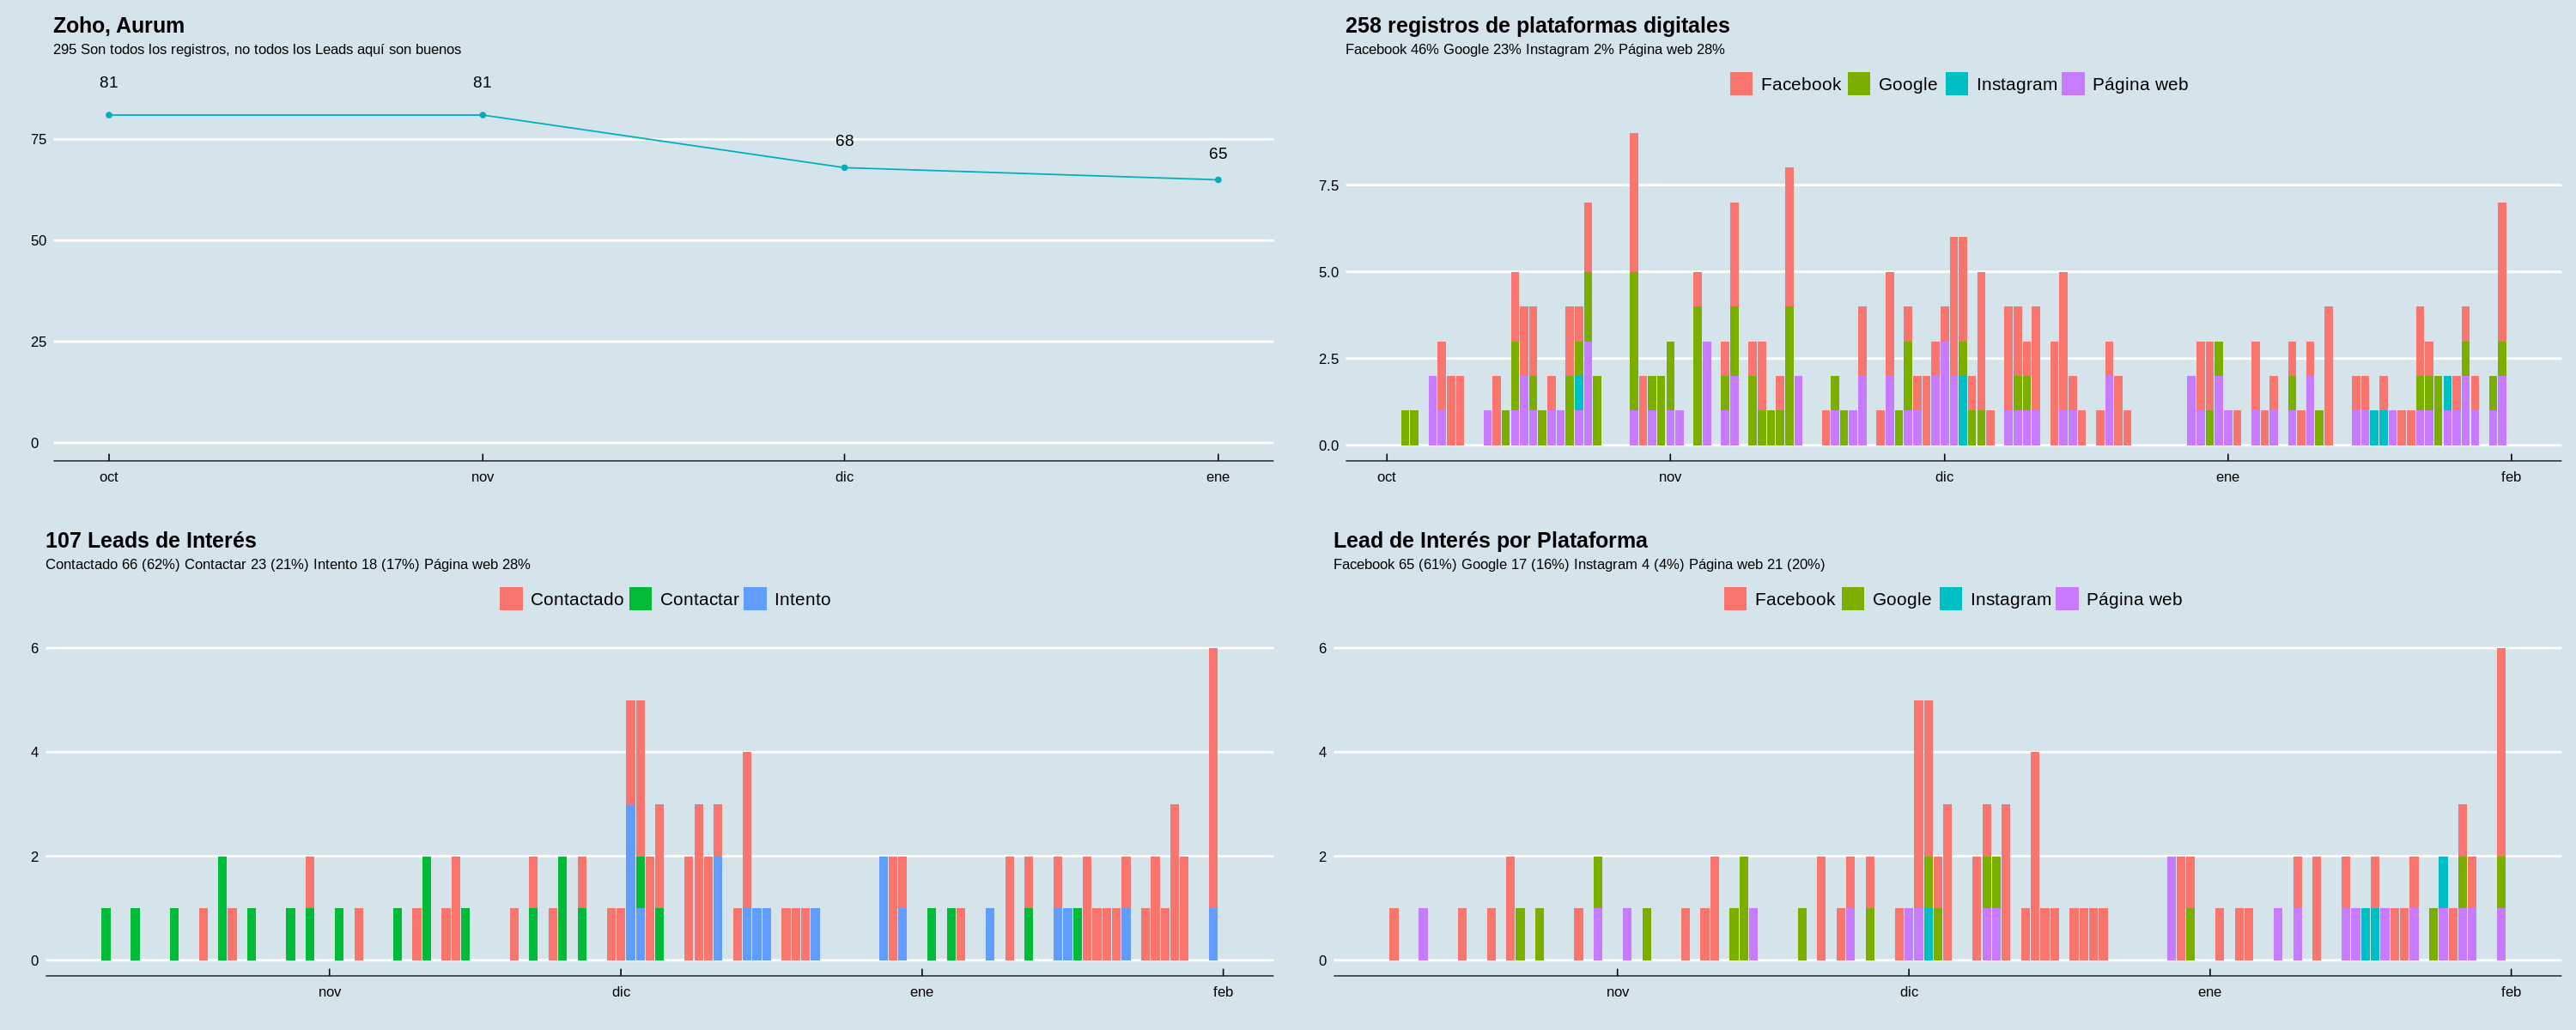

In [24]:
data.frame(Zoho("Aurum")[2])

## Plataformas

Año,Mes,Plataforma,Clics,Conversión,Inversión
<dbl>,<ord>,<fct>,<chr>,<dbl>,<chr>
2019,oct,Facebook,320,28,"$8,465"
2019,oct,Google,"1,612",35,"$40,307"
2019,nov,Facebook,510,32,"$18,186"
2019,nov,Google,"2,427",45,"$35,180"
2019,dic,Facebook,385,43,"$12,307"
2019,dic,Google,591,17,"$5,127"
2020,ene,Facebook,334,36,"$13,290"
2020,ene,Google,748,3,"$9,937"
2020,feb,Facebook,465,25,"$10,869"


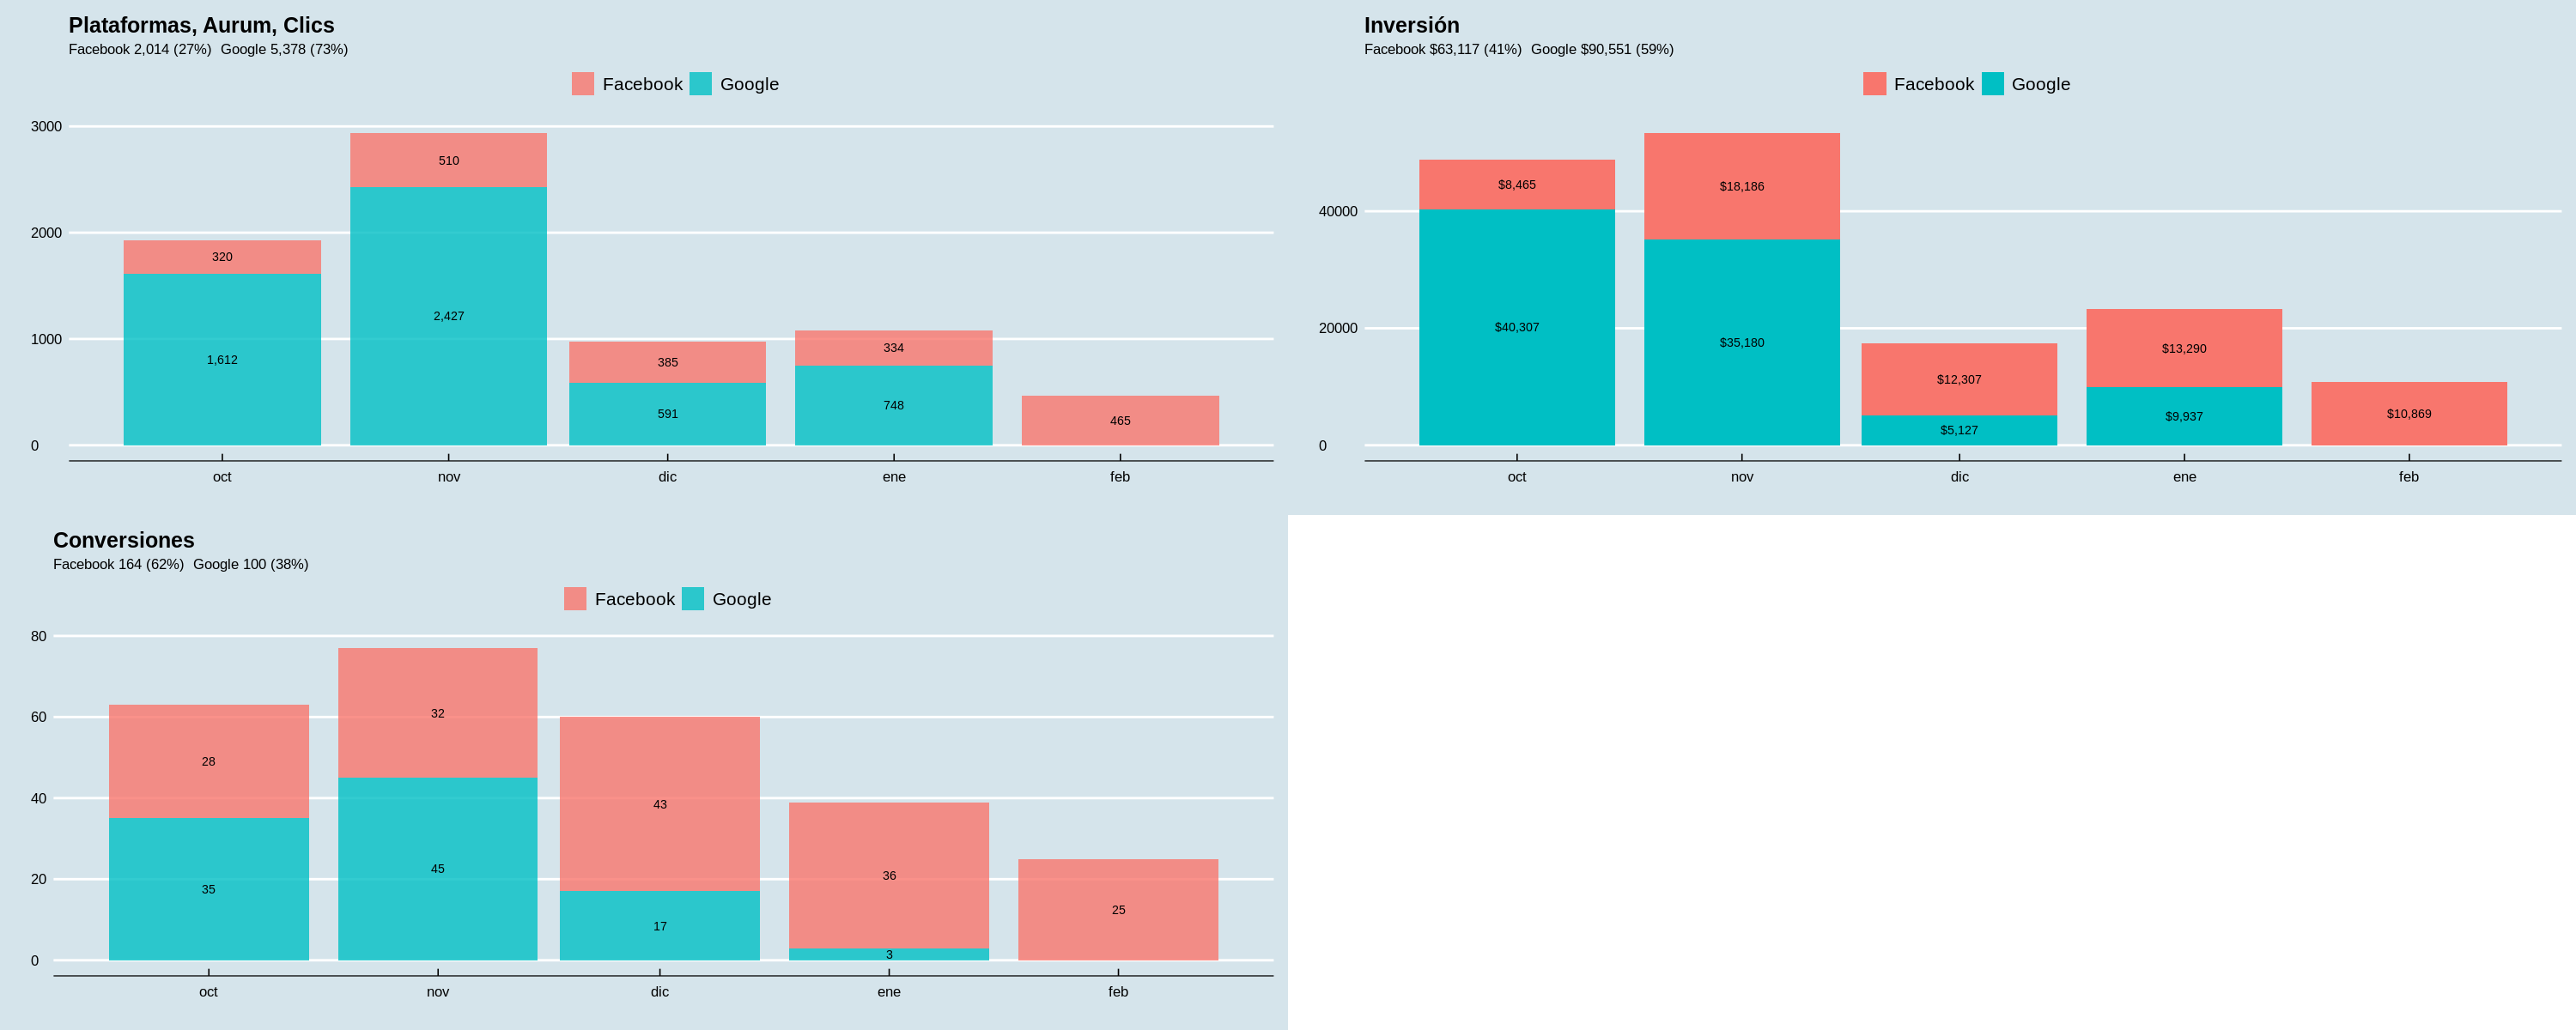

In [25]:
data.frame(Plataformas_graficas("Aurum")[2])

# Cumbres Herradura

## Zoho

Año,Mes,Plataforma,Leads.Interés
<dbl>,<ord>,<chr>,<int>
2019,ene,Facebook,20
2019,ene,Google,6
2019,ene,Instagram,3
2019,feb,Facebook,14
2019,feb,Google,5
2019,feb,Instagram,3
2019,mar,Facebook,8
2019,mar,Google,1
2019,mar,Instagram,3


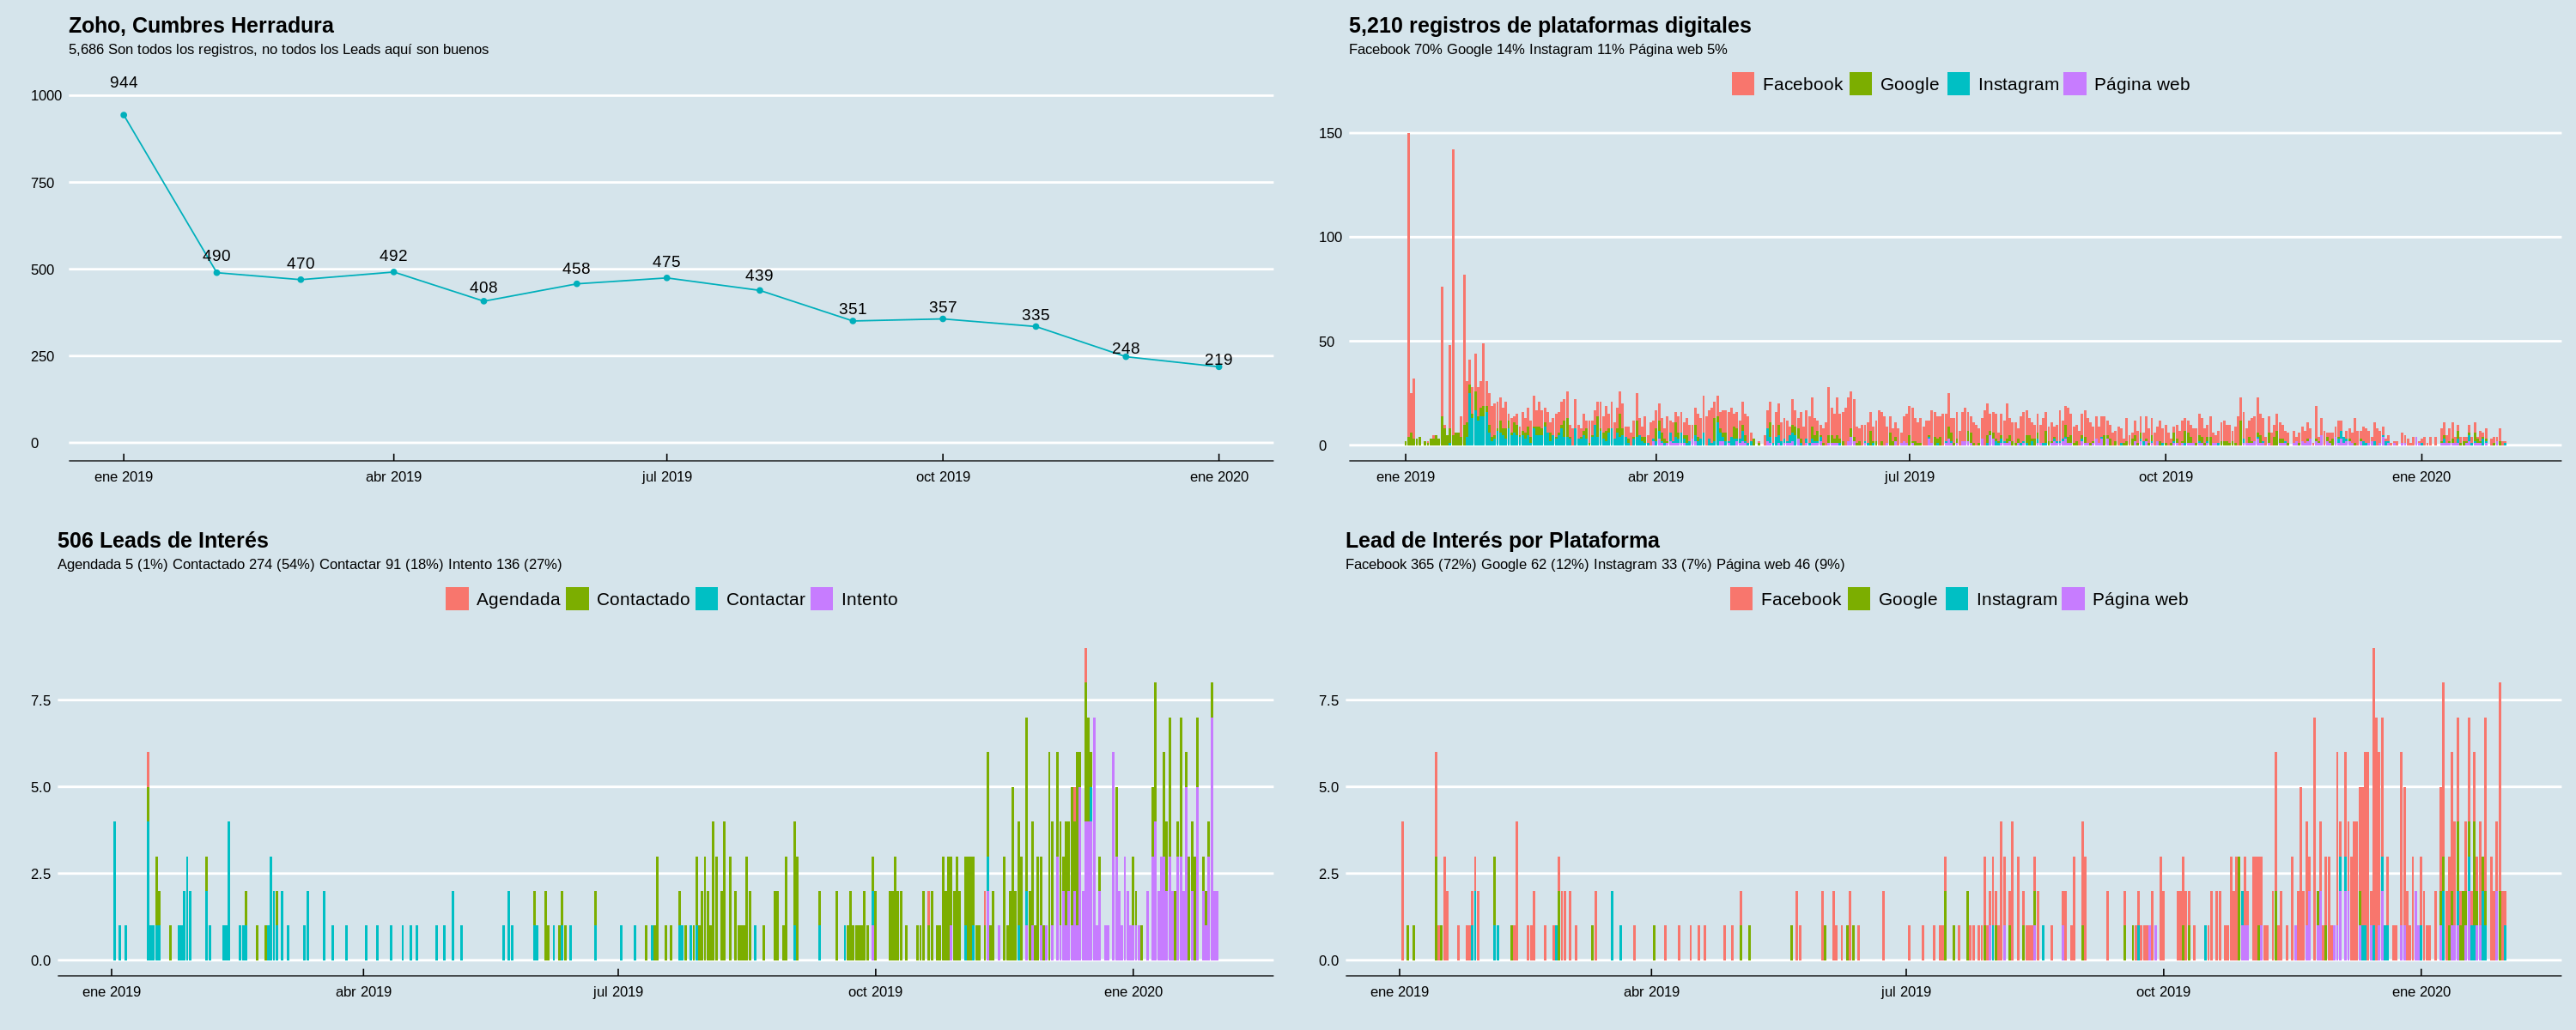

In [26]:
data.frame(Zoho("Cumbres Herradura")[2])

## Plataformas

Año,Mes,Plataforma,Clics,Conversión,Inversión
<dbl>,<ord>,<fct>,<chr>,<dbl>,<chr>
2019,ene,Facebook,"5,525",869.00,"$27,622"
2019,ene,Google,"1,858",8.00,"$13,590"
2019,feb,Facebook,"2,887",635.00,"$20,145"
2019,feb,Google,"1,871",37.00,"$19,010"
2019,mar,Facebook,"2,800",553.00,"$19,764"
2019,mar,Google,"6,702",19.00,"$24,694"
2019,abr,Facebook,"2,625",408.00,"$18,946"
2019,abr,Google,"8,158",23.00,"$25,325"
2019,may,Facebook,"2,369",331.00,"$20,487"


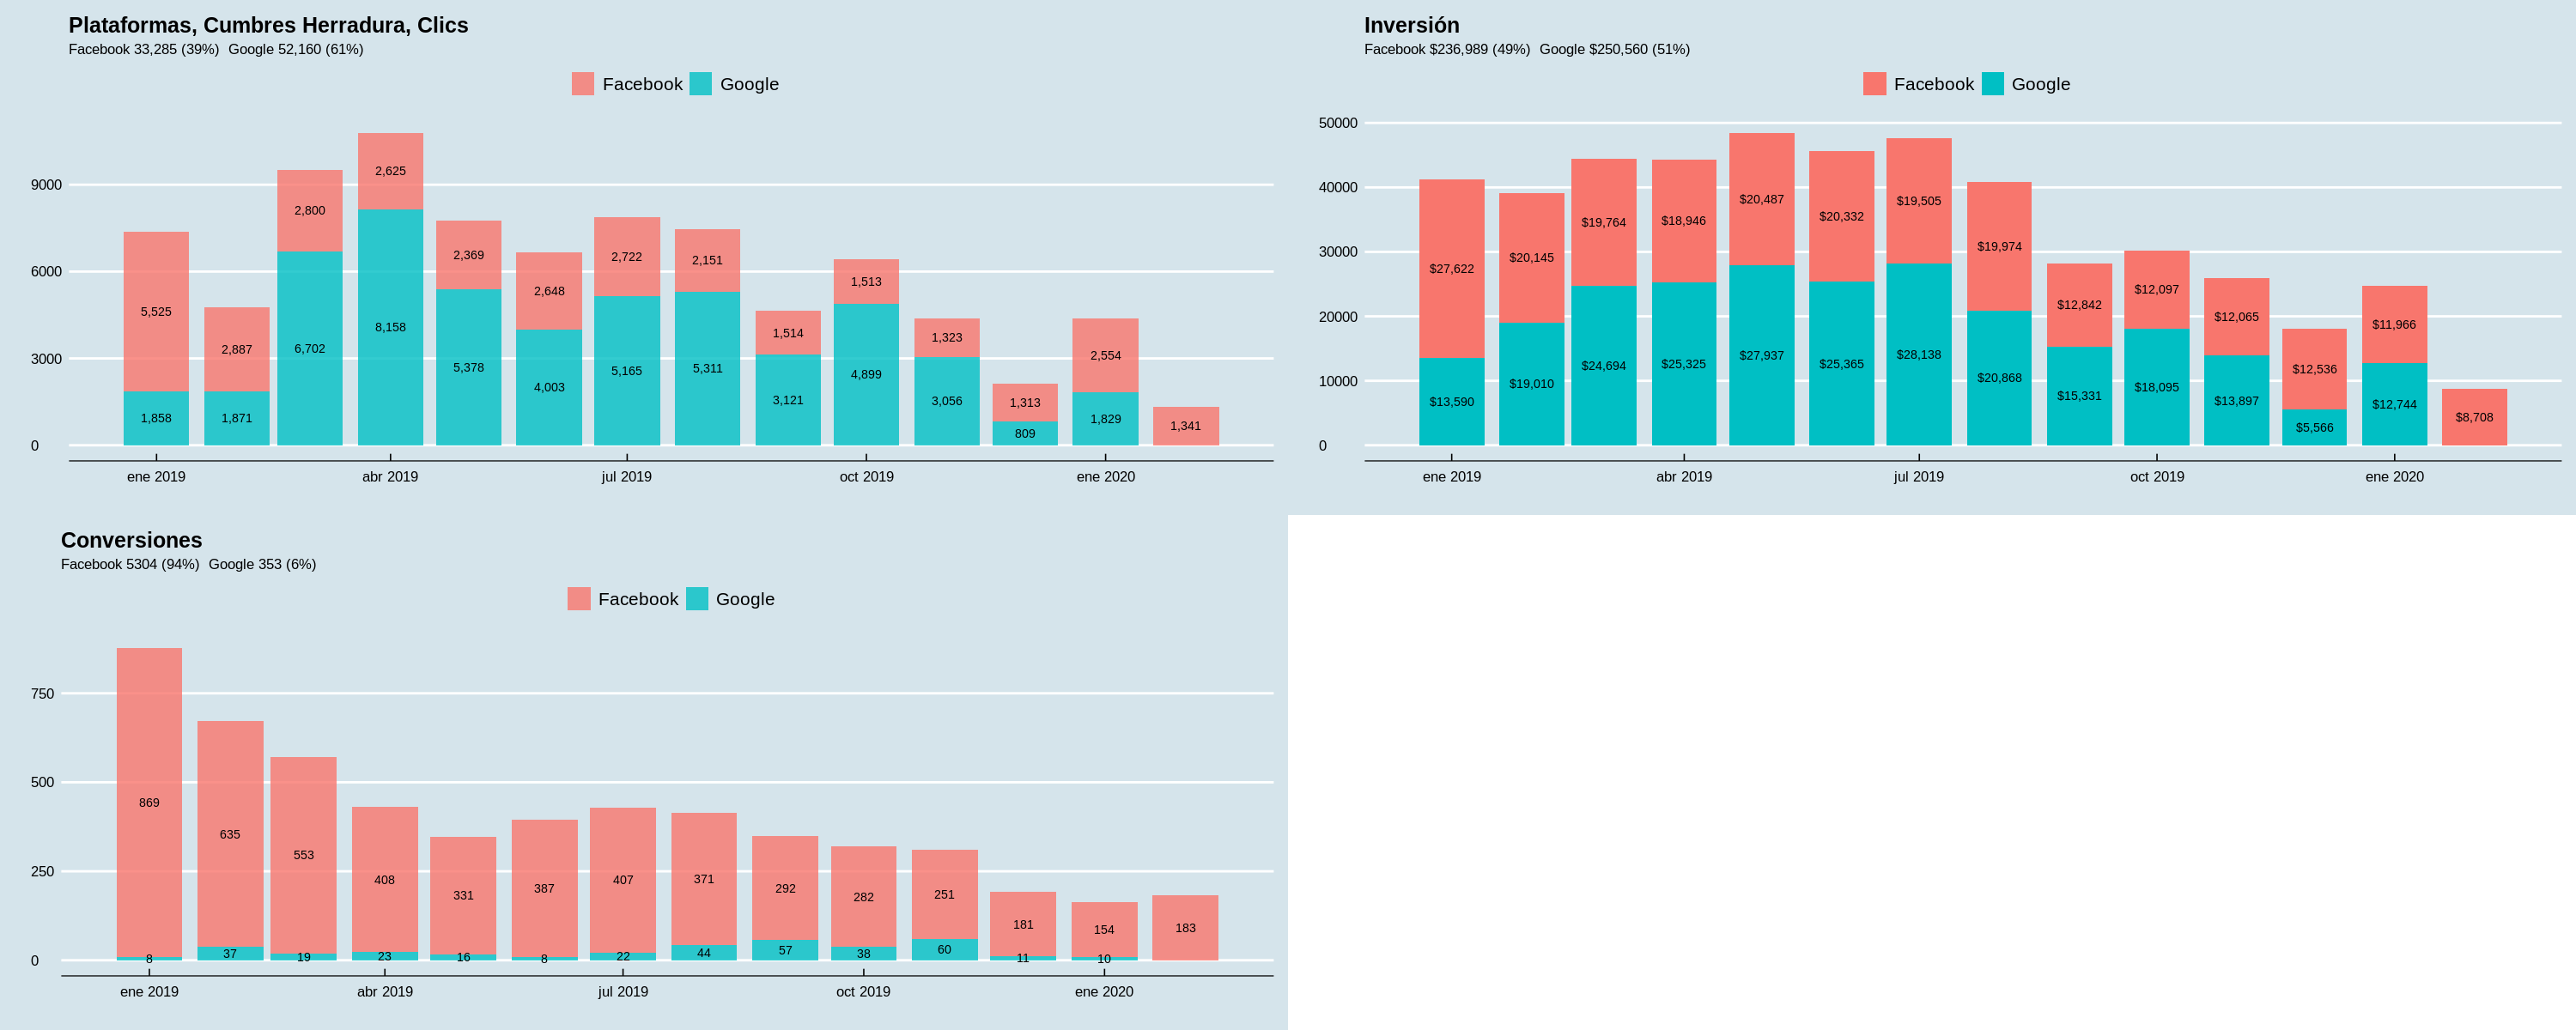

In [27]:
data.frame(Plataformas_graficas("Cumbres Herradura")[2])

# El Cortijo

## Zoho

Año,Mes,Plataforma,Leads.Interés
<dbl>,<ord>,<chr>,<int>
2019,ene,Google,3
2019,feb,Google,3
2019,mar,Google,2
2019,abr,Facebook,1
2019,abr,Google,2
2019,abr,Página web,2
2019,jun,Facebook,2
2019,jun,Google,1
2019,jul,Página web,1


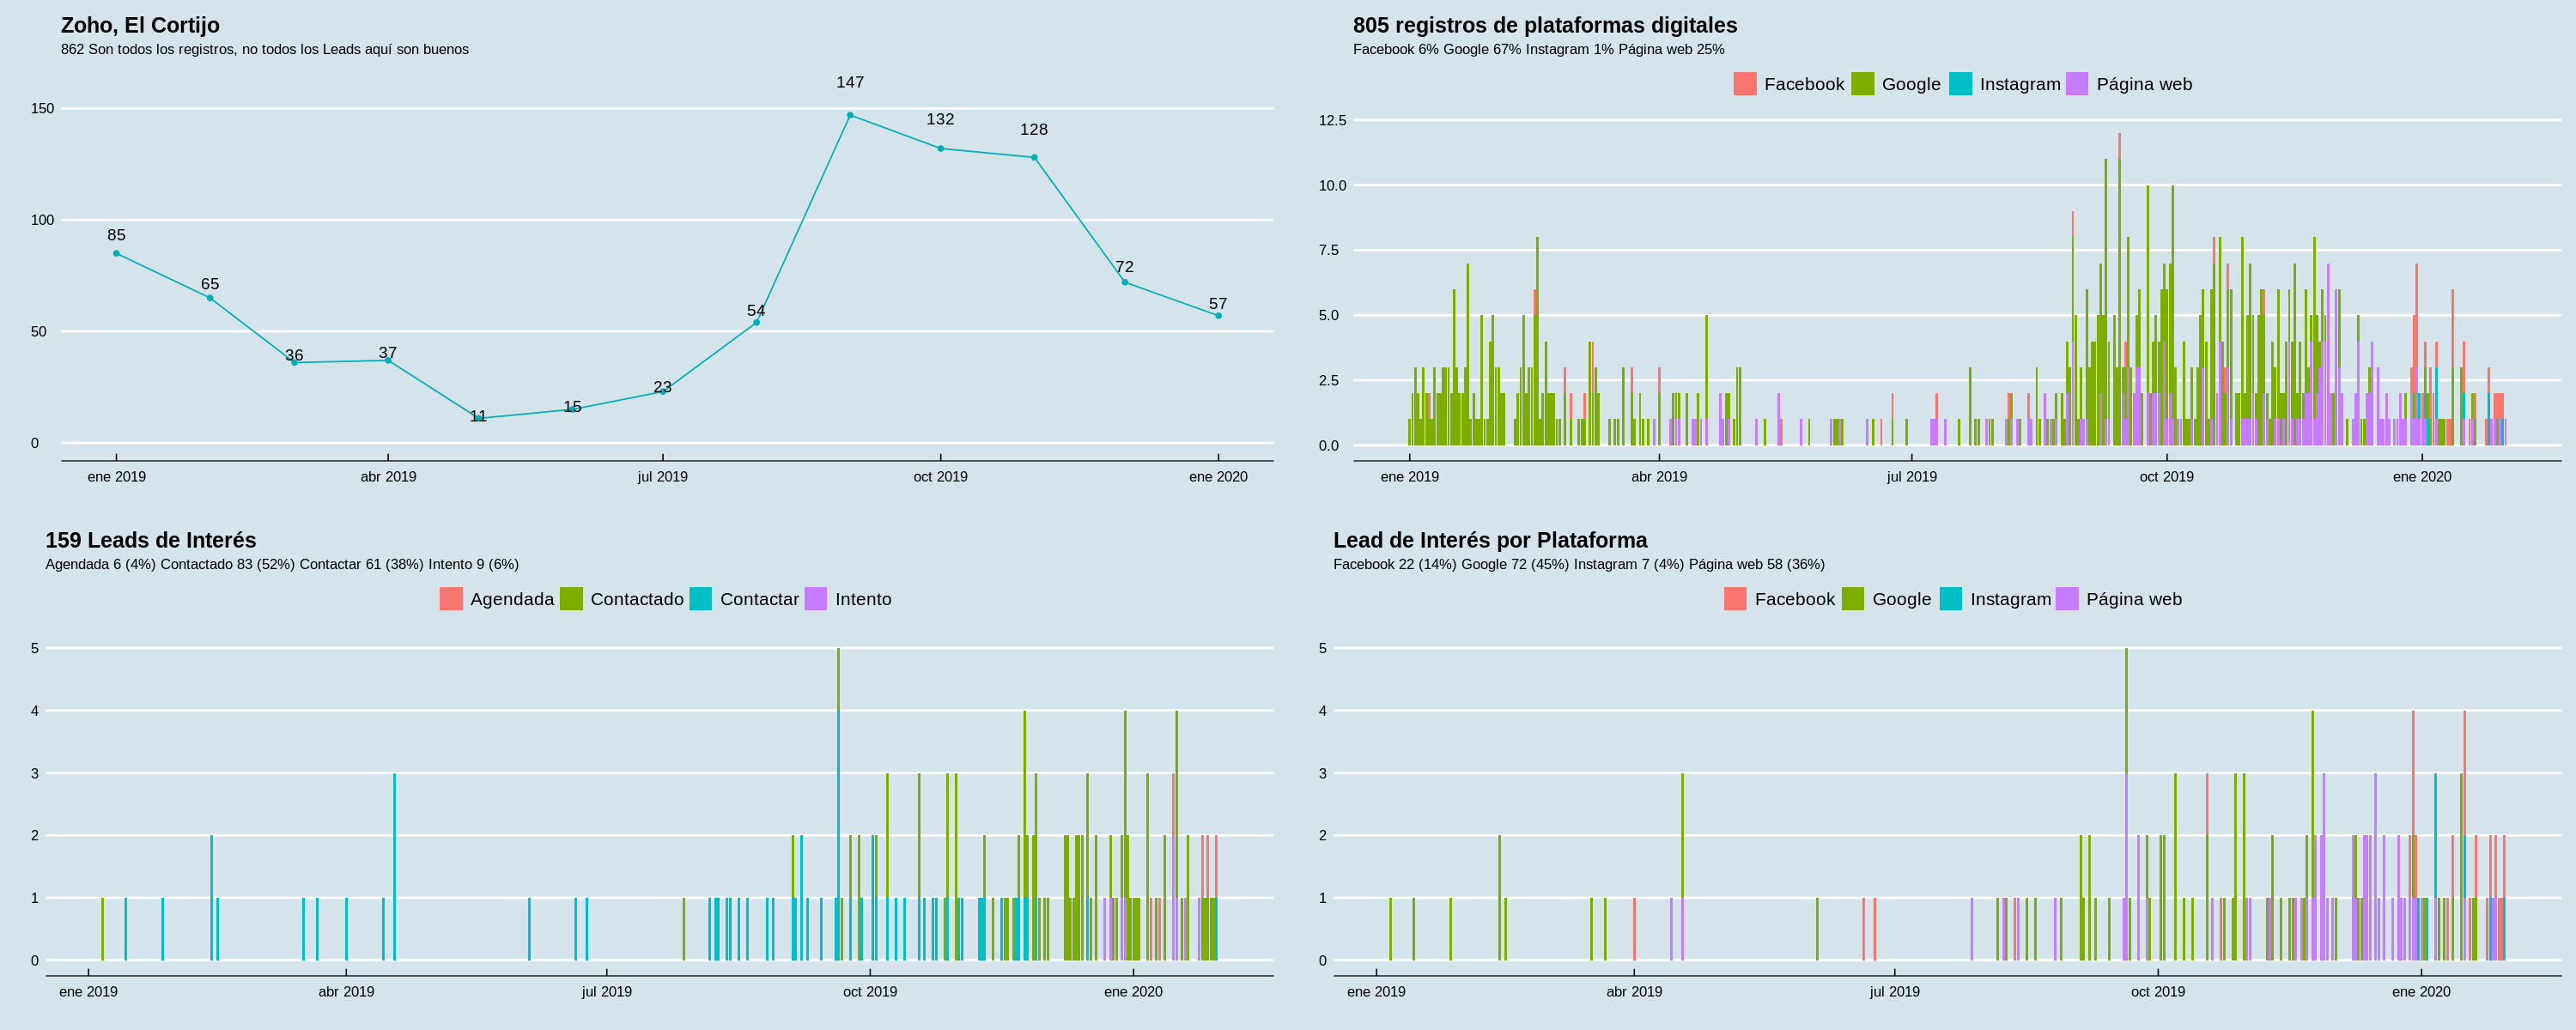

In [28]:
data.frame(Zoho("El Cortijo")[2])

## Plataformas

Año,Mes,Plataforma,Clics,Conversión,Inversión
<dbl>,<ord>,<fct>,<chr>,<dbl>,<chr>
2019,ene,Facebook,0,0.00,$0
2019,ene,Google,"7,494",48.00,"$21,140"
2019,feb,Facebook,0,0.00,$0
2019,feb,Google,"6,991",34.00,"$20,138"
2019,mar,Facebook,0,0.00,$0
2019,mar,Google,"4,770",14.00,"$14,097"
2019,abr,Facebook,0,0.00,$0
2019,abr,Google,"4,964",15.17,"$15,773"
2019,may,Facebook,0,0.00,$0


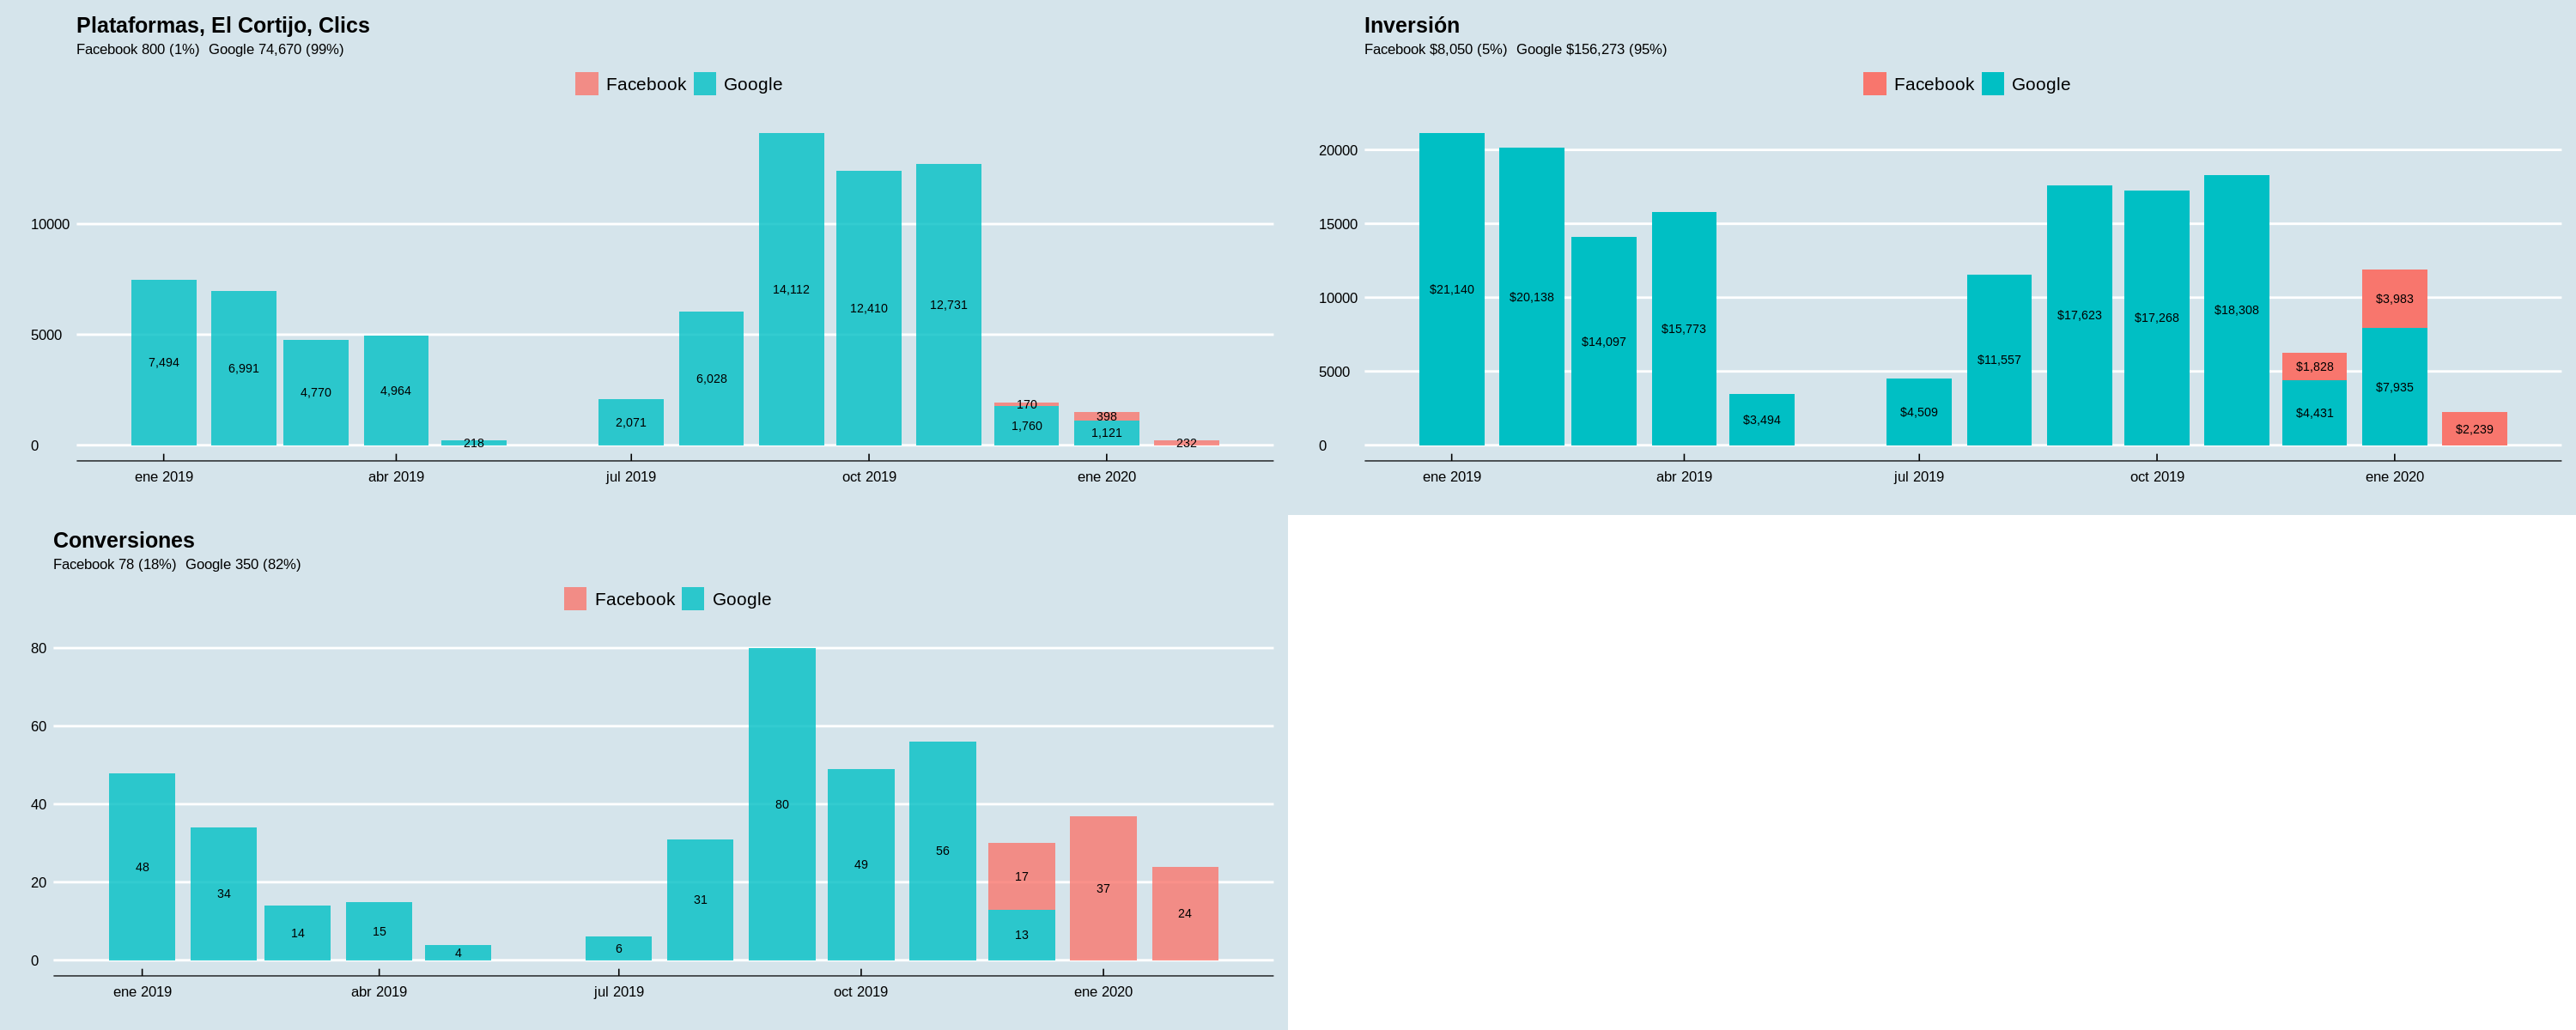

In [29]:
data.frame(Plataformas_graficas("El Cortijo")[2])

# Parque Hacienda

## Zoho

Año,Mes,Plataforma,Leads.Interés
<dbl>,<ord>,<chr>,<int>
2019,jul,Facebook,1
2019,ago,Google,1
2019,nov,Facebook,1
2019,nov,Google,2
2019,nov,Página web,1
2019,dic,Facebook,17
2019,dic,Google,3
2019,dic,Instagram,2
2019,dic,Página web,4


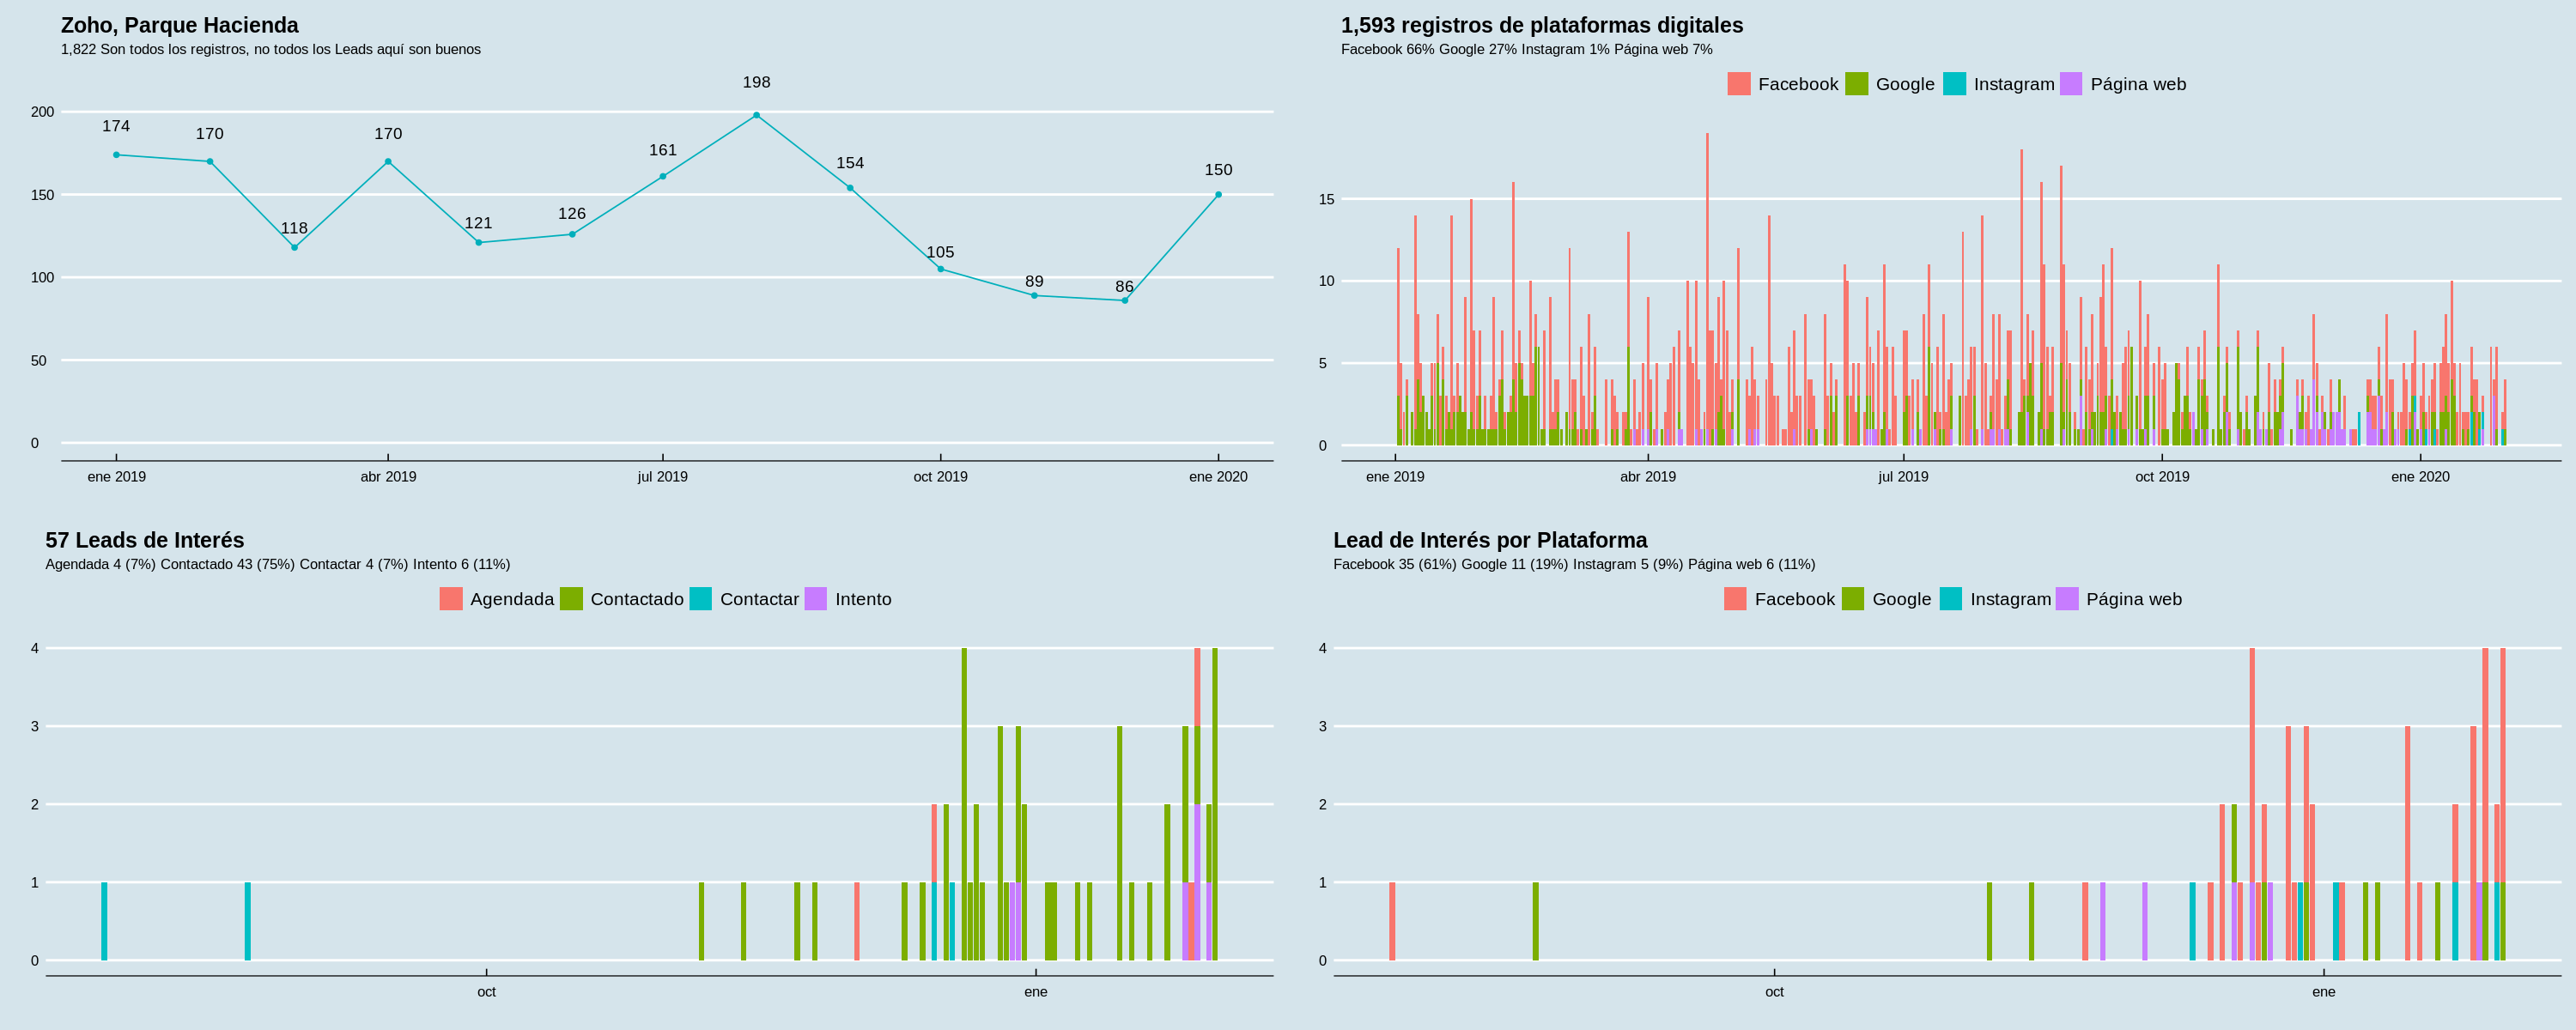

In [30]:
data.frame(Zoho("Parque Hacienda")[2])

## Plataformas

Año,Mes,Plataforma,Clics,Conversión,Inversión
<dbl>,<ord>,<fct>,<chr>,<dbl>,<chr>
2019,ene,Facebook,"1,924",93.00,"$12,758"
2019,ene,Google,"15,720",26.00,"$6,447"
2019,feb,Facebook,"1,398",65.00,"$13,208"
2019,feb,Google,"21,063",30.00,"$6,908"
2019,mar,Facebook,"1,382",48.00,"$11,677"
2019,mar,Google,"14,595",4.00,"$6,960"
2019,abr,Facebook,"2,224",63.00,"$15,560"
2019,abr,Google,"33,939",1.00,"$11,741"
2019,may,Facebook,"1,526",45.00,"$16,588"


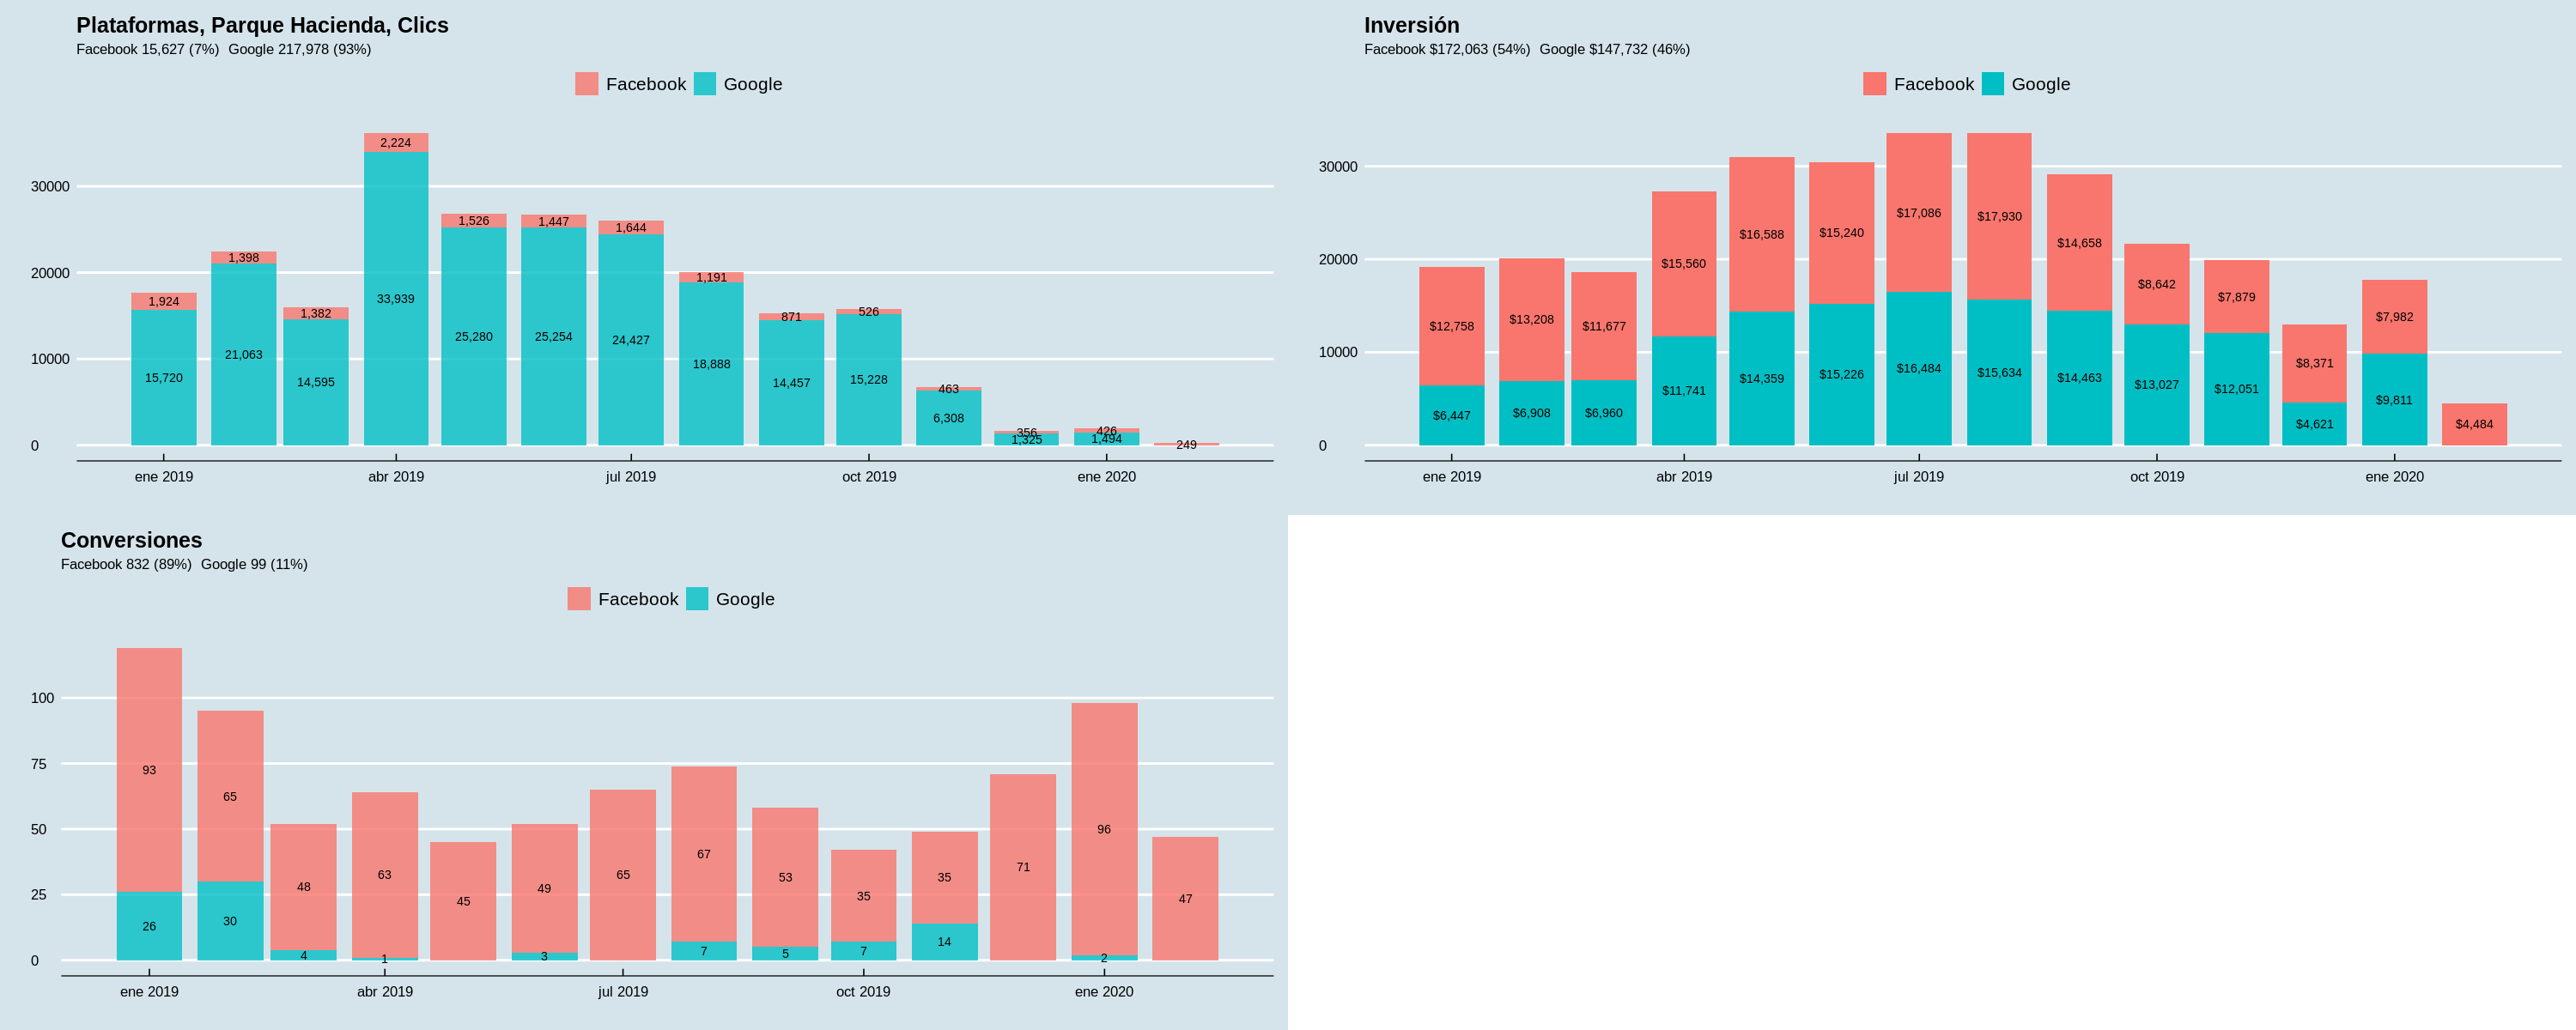

In [31]:
data.frame(Plataformas_graficas("Parque Hacienda")[2])

# Real de Lutecia

## Zoho

Año,Mes,Plataforma,Leads.Interés
<dbl>,<ord>,<chr>,<int>
2019,ene,Facebook,1
2019,feb,Google,2
2019,mar,Google,2
2019,abr,Facebook,4
2019,abr,Google,2
2019,may,Página web,1
2019,jun,Facebook,3
2019,jul,Facebook,8
2019,jul,Google,1


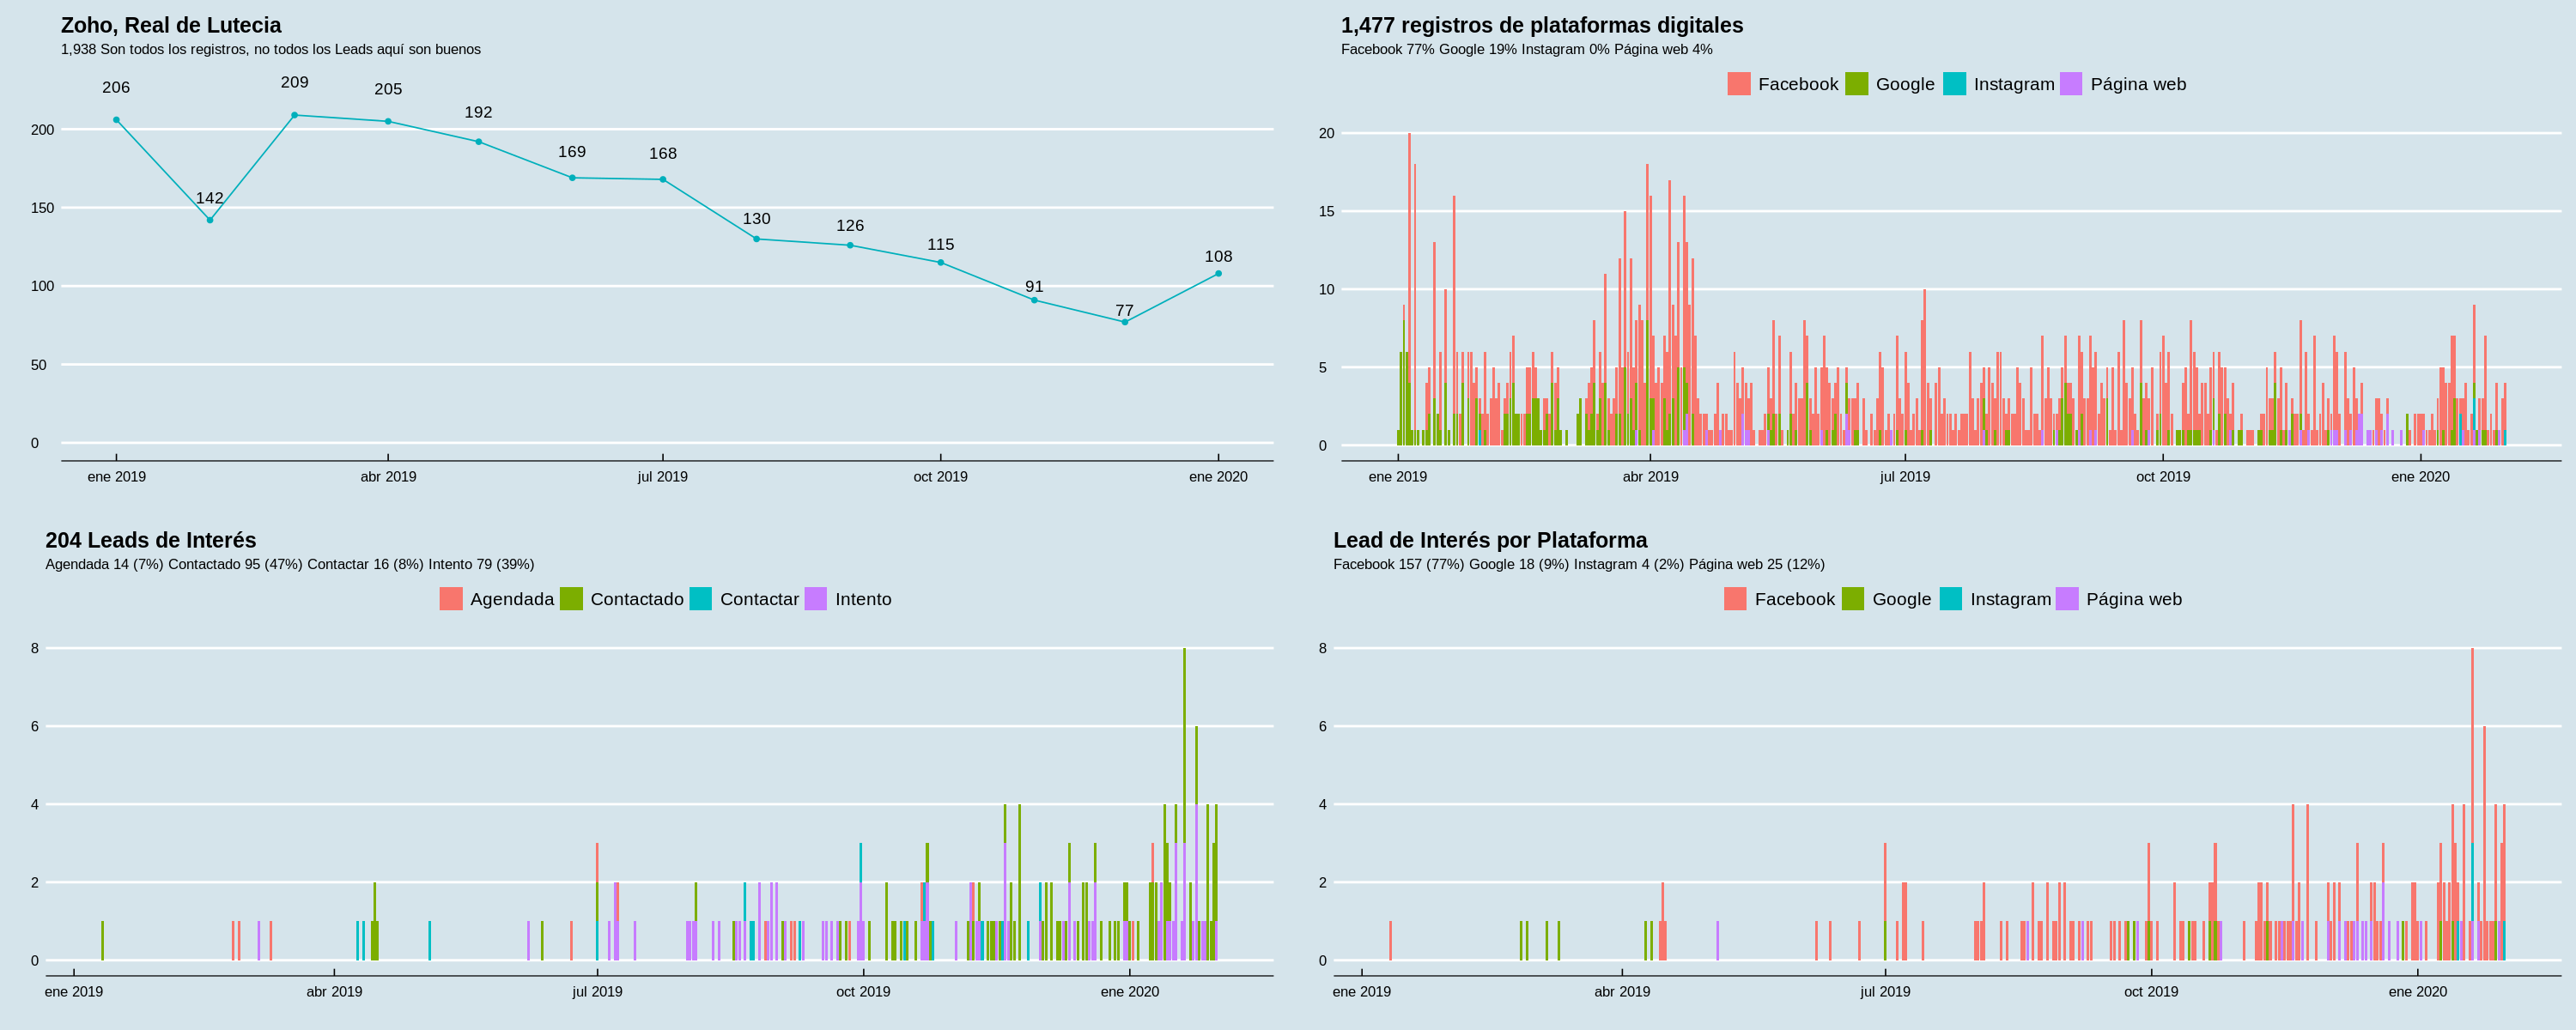

In [32]:
data.frame(Zoho("Real de Lutecia")[2])

## Plataformas

Año,Mes,Plataforma,Clics,Conversión,Inversión
<dbl>,<ord>,<fct>,<chr>,<dbl>,<chr>
2019,ene,Facebook,"2,164",113,"$16,959"
2019,ene,Google,"4,361",1,"$15,386"
2019,feb,Facebook,"1,630",70,"$20,911"
2019,feb,Google,"5,544",2,"$17,060"
2019,mar,Facebook,"2,392",120,"$16,653"
2019,mar,Google,"4,260",10,"$16,013"
2019,abr,Facebook,"3,754",154,"$17,146"
2019,abr,Google,"2,817",9,"$14,470"
2019,may,Facebook,"3,417",89,"$16,717"


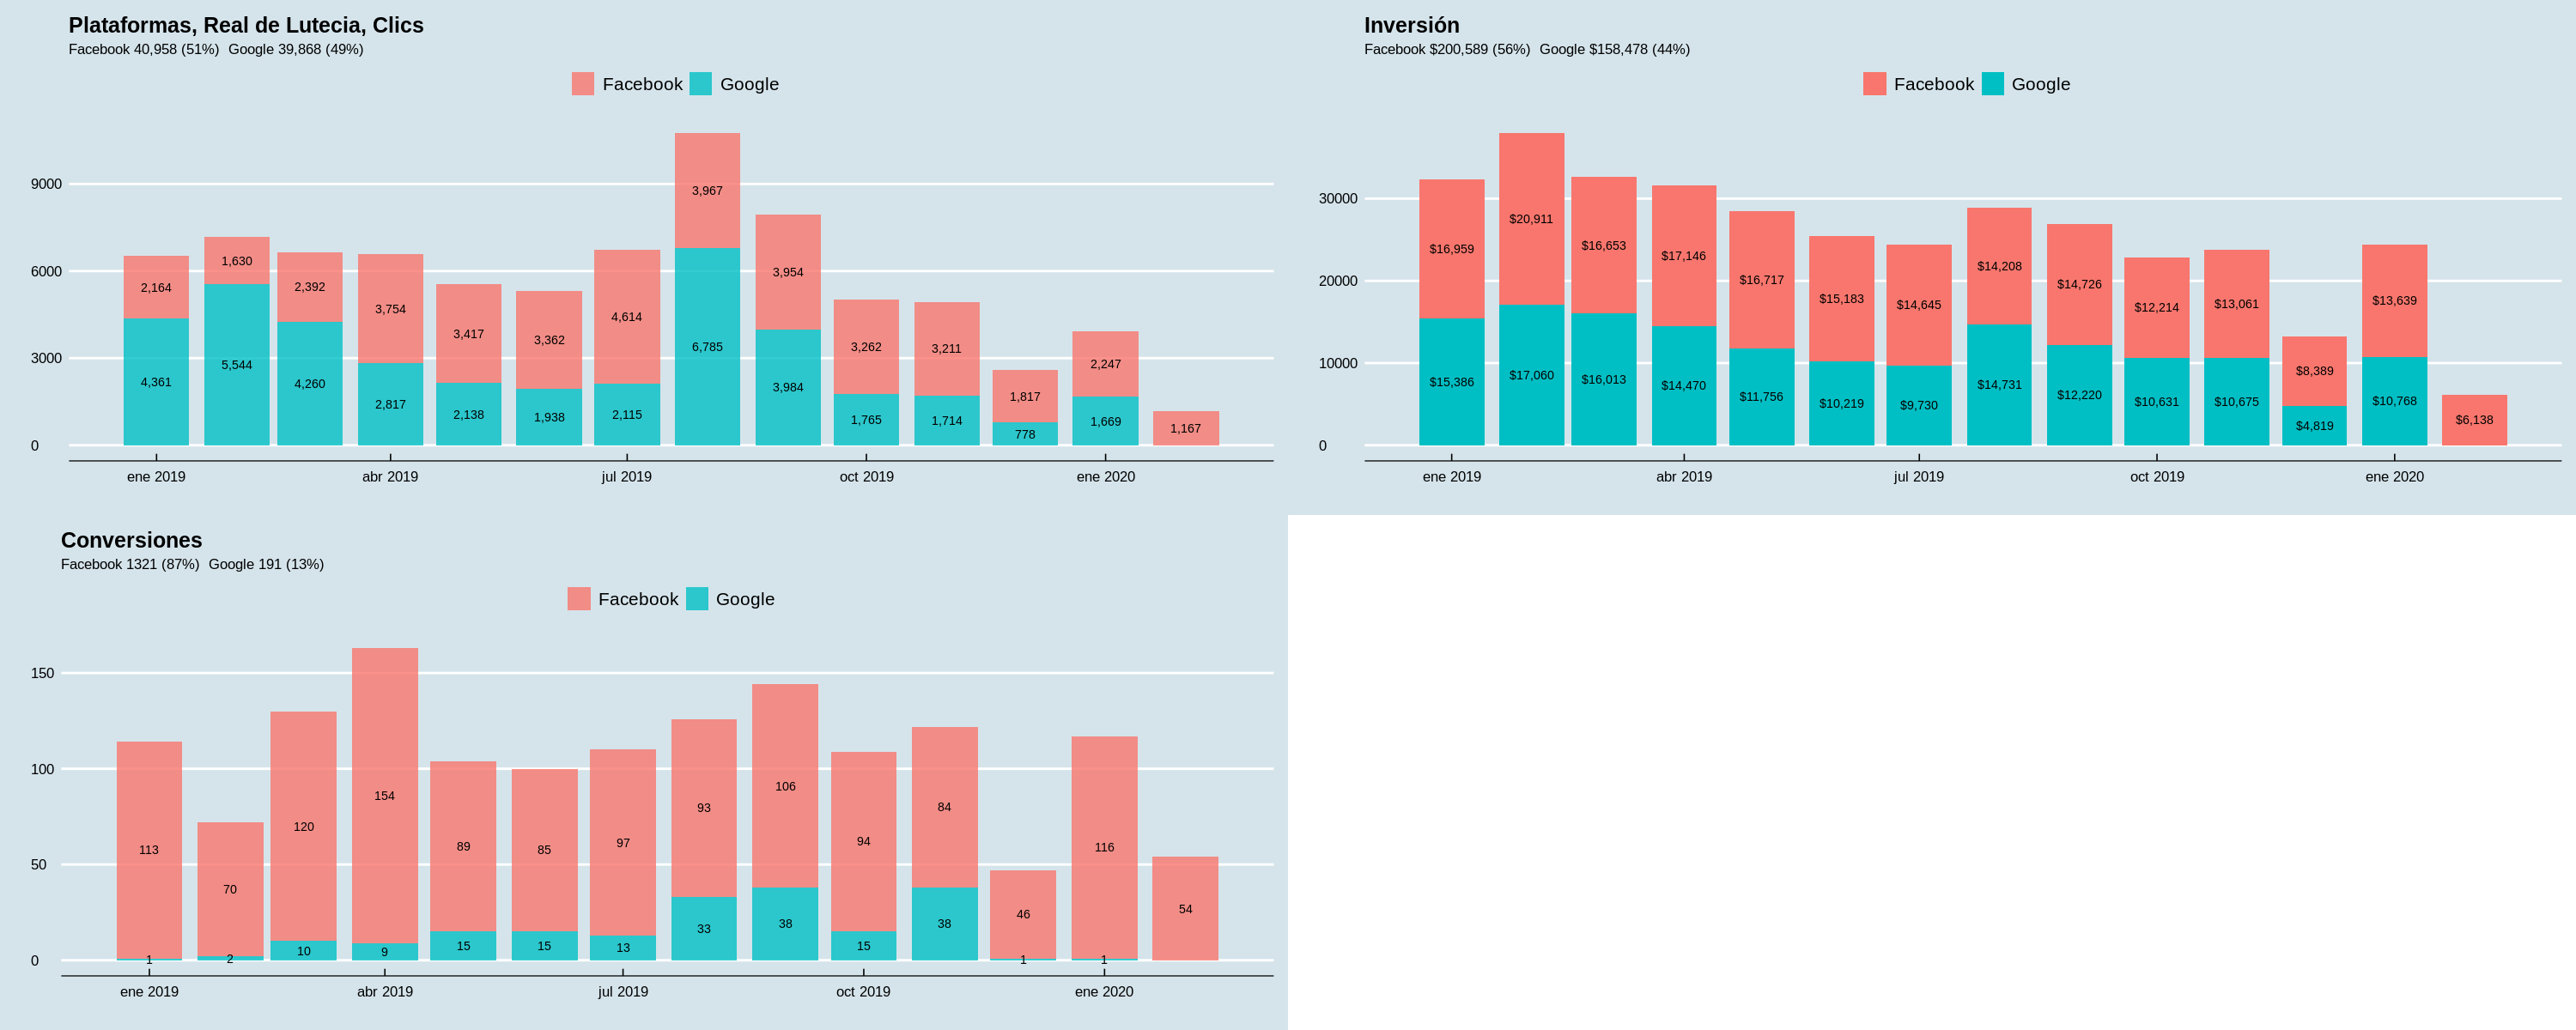

In [33]:
data.frame(Plataformas_graficas("Real de Lutecia")[2])

# Reserva del sur

## Zoho

Año,Mes,Plataforma,Leads.Interés
<dbl>,<ord>,<chr>,<int>
2019,ene,Facebook,4
2019,ene,Google,1
2019,feb,Facebook,8
2019,feb,Google,6
2019,mar,Facebook,3
2019,mar,Google,23
2019,mar,Página web,1
2019,abr,Facebook,13
2019,abr,Google,11


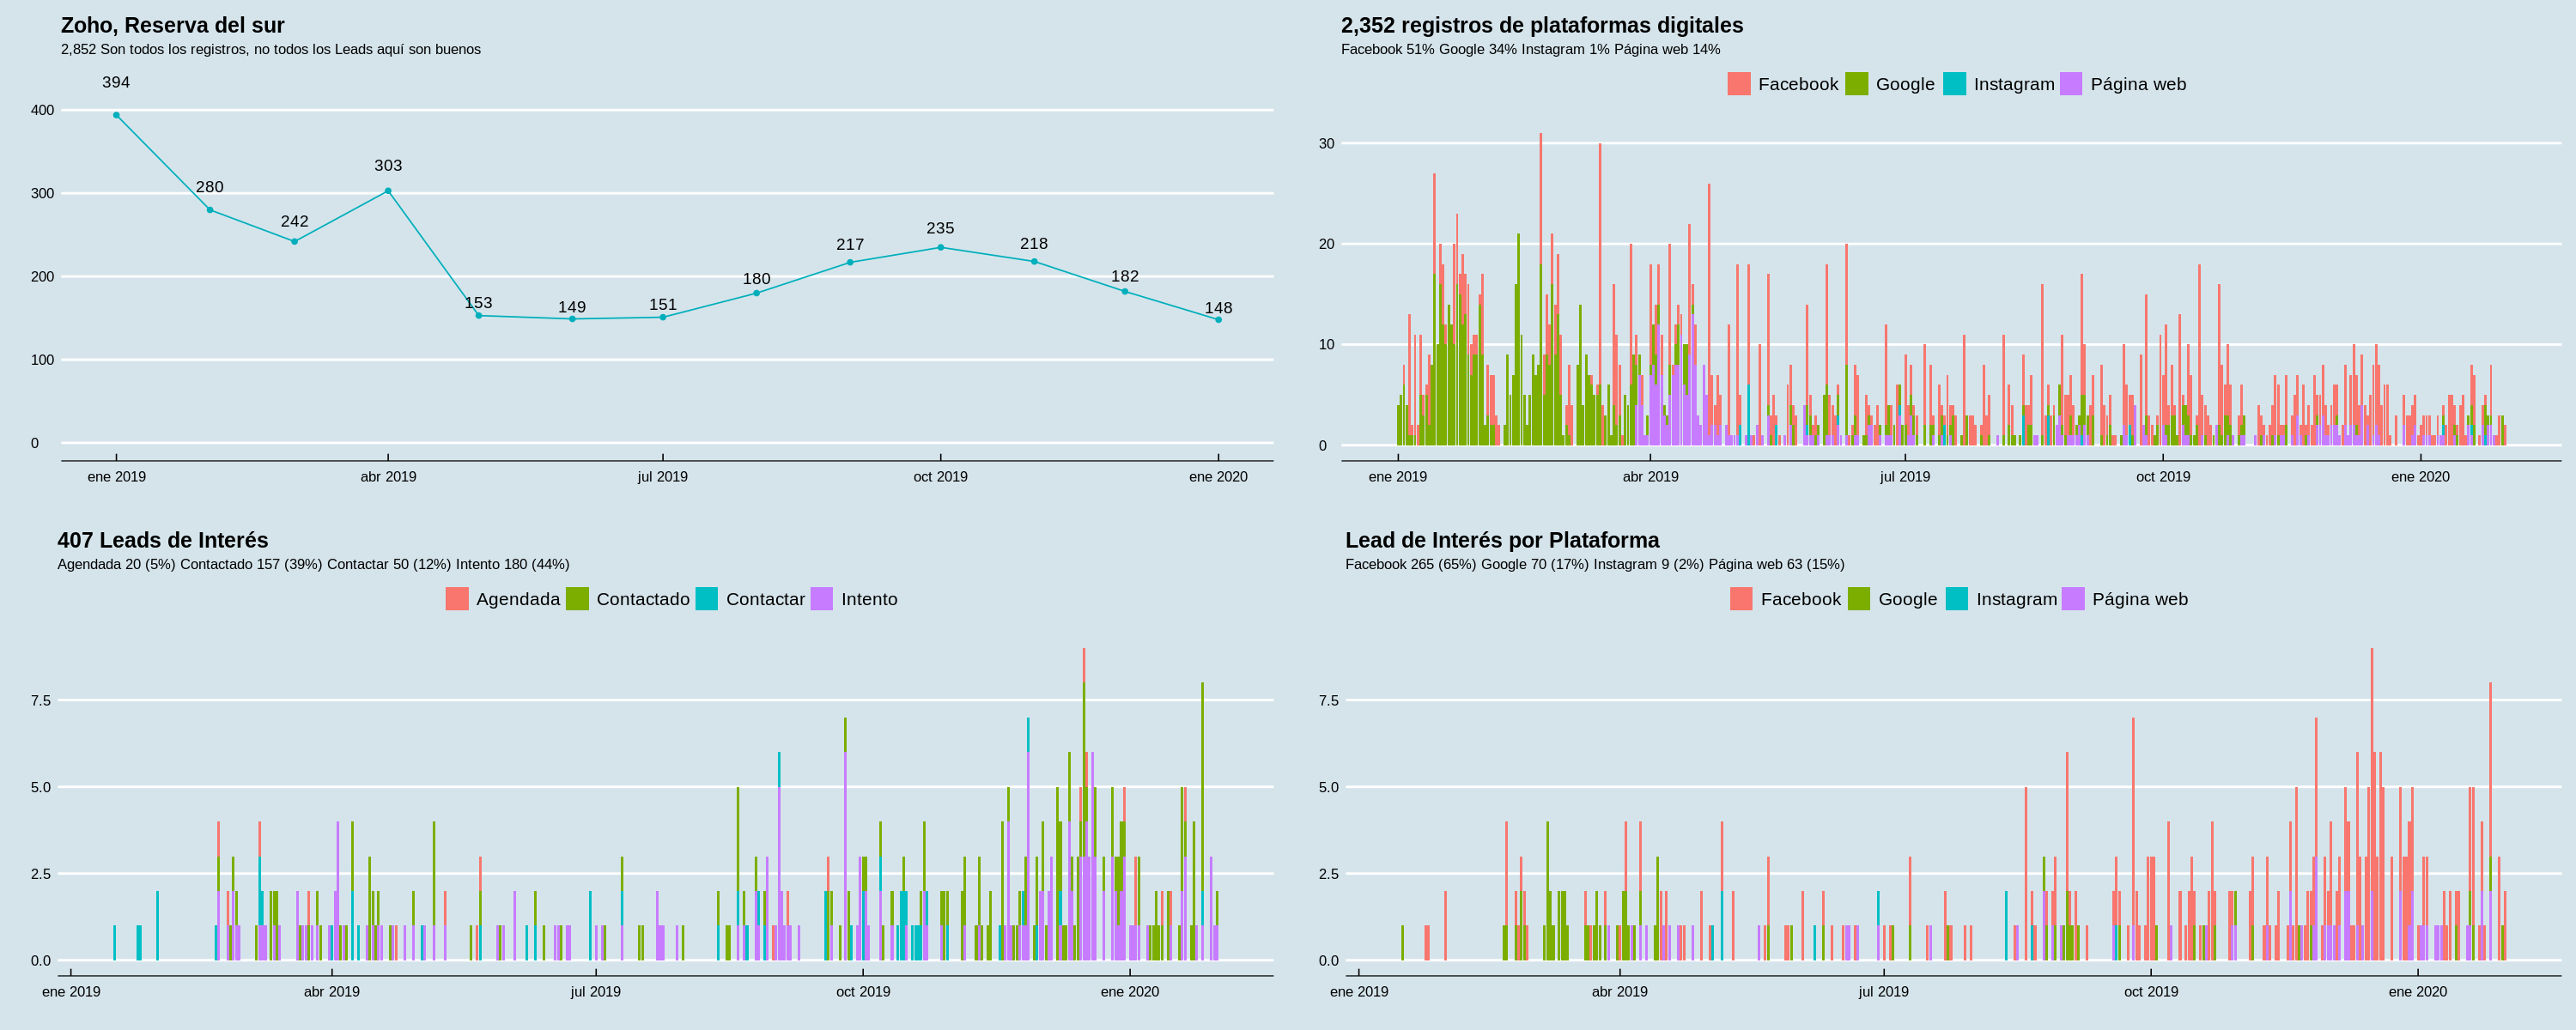

In [34]:
data.frame(Zoho("Reserva del sur")[2])

## Plataformas

Año,Mes,Plataforma,Clics,Conversión,Inversión
<dbl>,<ord>,<fct>,<chr>,<dbl>,<chr>
2019,ene,Facebook,"1,801",134,"$15,086"
2019,ene,Google,"11,815",80,"$13,131"
2019,feb,Facebook,"1,257",74,"$7,228"
2019,feb,Google,"10,534",95,"$12,181"
2019,mar,Facebook,"2,039",112,"$14,838"
2019,mar,Google,"9,585",37,"$14,044"
2019,abr,Facebook,"1,980",135,"$15,016"
2019,abr,Google,"6,529",20,"$11,640"
2019,may,Facebook,"1,599",116,"$14,919"


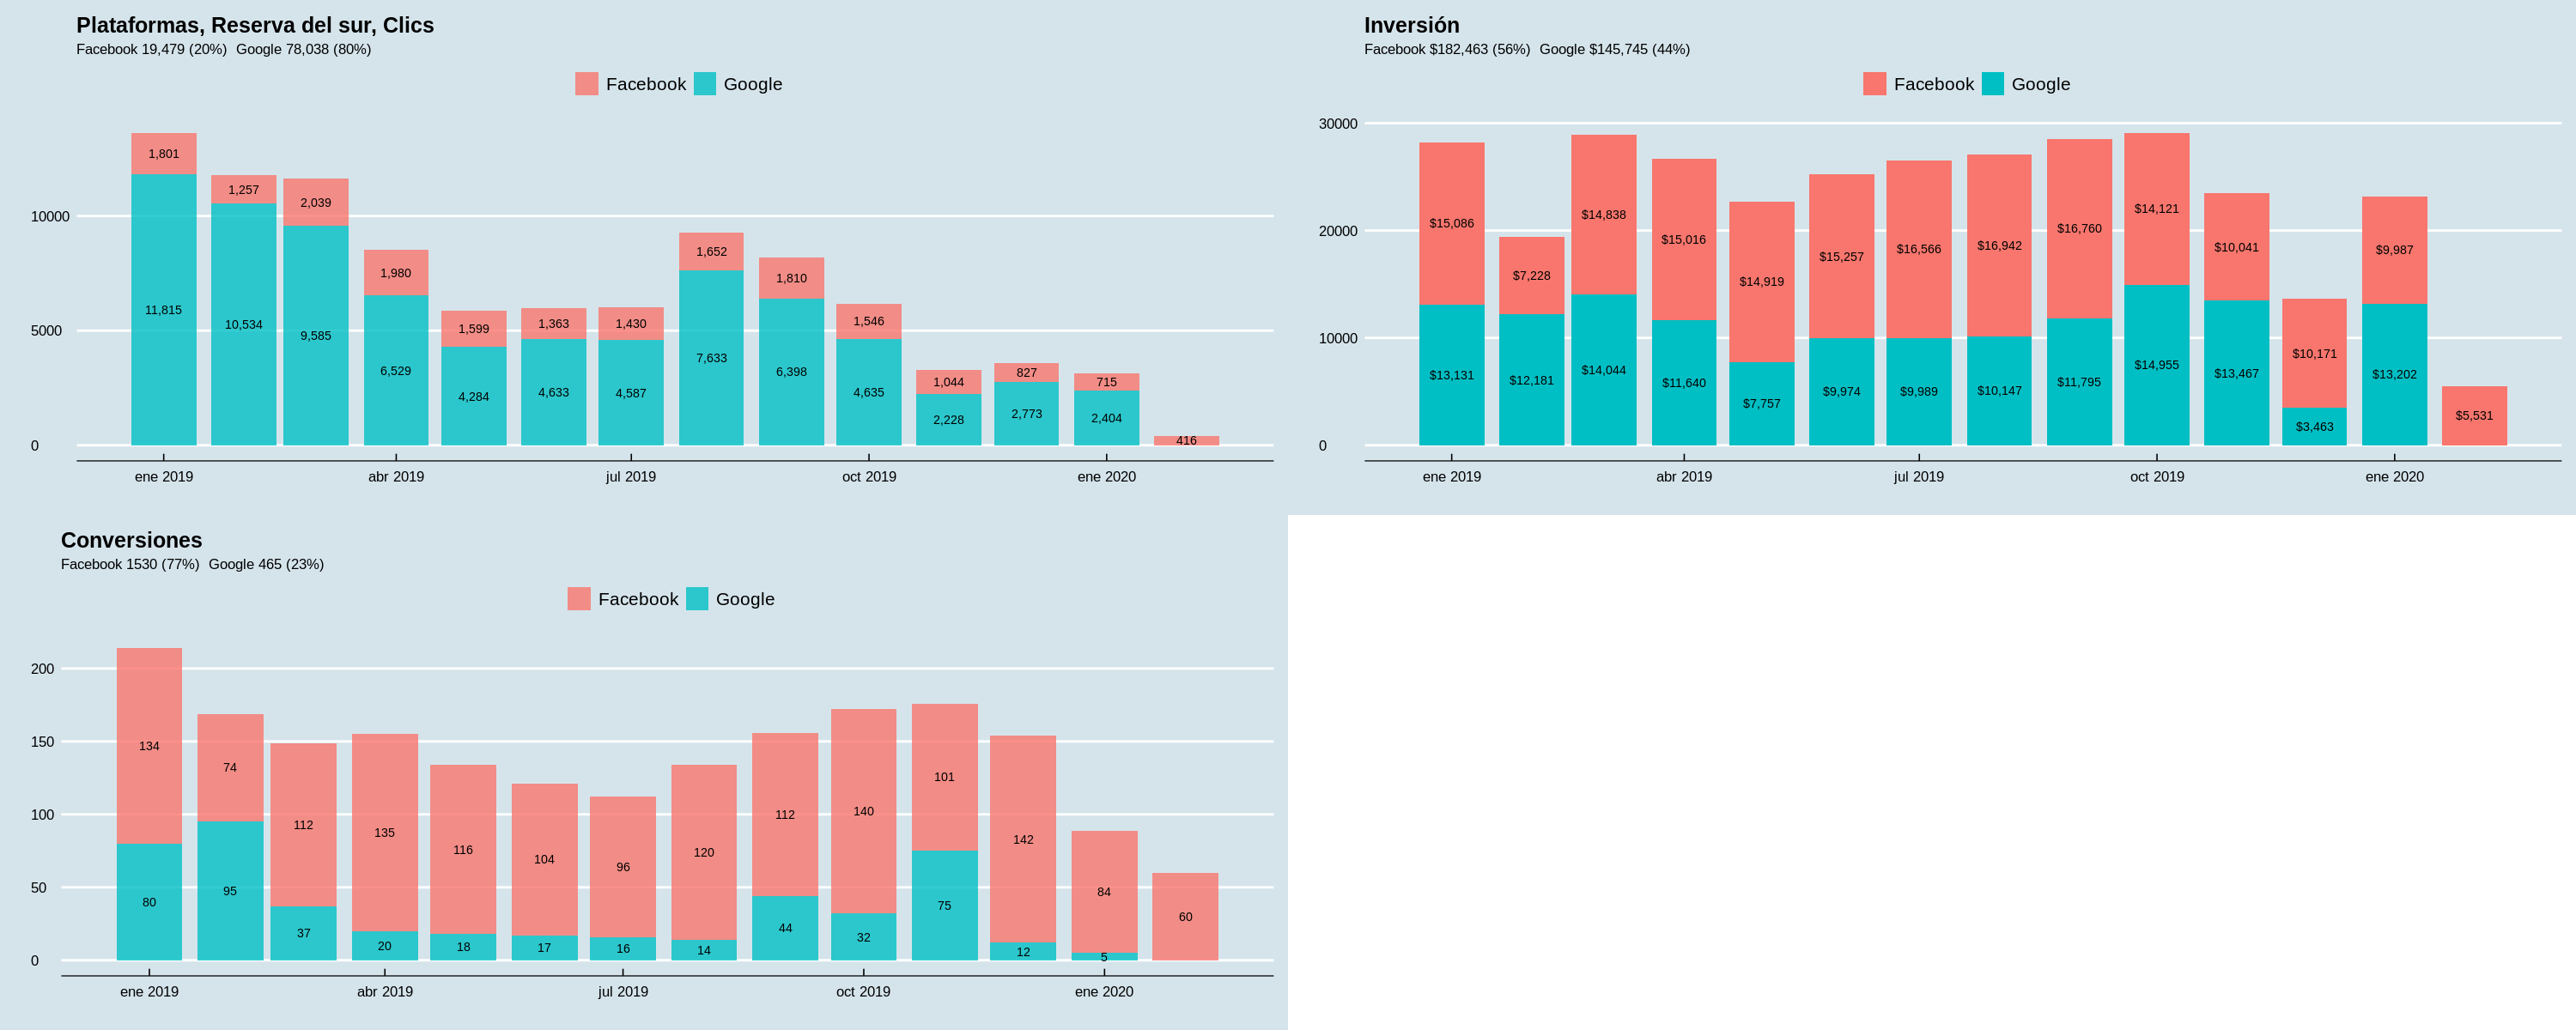

In [35]:
data.frame(Plataformas_graficas("Reserva del sur")[2])